# Step 2: Data Wrangling

The collected data will be prepped for model building here. In general:
- Blanks will be filled with either the average (numerical) or FALSE (boolean)
- Duplicate samples will be removed
- Data will be converted to consistent units
- Features will be engineered (outliers, etc.)
- Training data (recentlySold) will be modified en masse to have a matching statistical distribution as 'live' data (forSale)

There are two primary steps in this process:
1) Narrow down feature set from 600+ features (manual selection)
2) Clean, organize, scale, and engineer data for use in model building

---

In [1]:
'''
Import libraries
'''

import pandas as pd
import numpy as np
import csv
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, zscore
from scipy.special import boxcox1p

pd.options.display.max_columns = None

import seaborn as sns
import warnings
from scipy.stats import skew
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set_theme(style='white', context='notebook', palette='deep')
# %config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
# %matplotlib inline

In [2]:
'''
Define Zillow data parameters
'''

# IMPORTANT: 'priceRange' here MuST match the 'priceRange' found in the data collection step.
priceRange = [
    [1, 250000], [250001, 300000], [300001, 350000], [350001, 400000],
    [400001, 450000], [450001, 500000], [500001, 750000], [750001, 1000000],
    [1000001, 2000000], [2000001, 5000000], [5000001, 50000000]
    ]

outlierBoolean_fs = []
outlierBoolean_rs = []

In [3]:
'''
Data Distribution Variables
'''

removeOutliers = False # Remove outliers before scaling and exporting to CSV?
OHE_on = True # Turn on or off the one-hot-encoded variables.

In [4]:
'''
Build helper functions for code cleanliness
'''

def hoaFees(series: pd.DataFrame):
    '''
    Standardizes the units for HOA fees to monthly.

    ## Parameters:
    - series: Input data as pd.Series.

    ## Returns:
    - payment: Output data as pd.Series.
    '''
    paymentFreq = series.apply(lambda x: str(x).strip("$,1234567890 "))
    payment = series.apply(lambda x: str(x).strip("$,-abcdefghijklmnopqrstuvwxyz ").replace(',', ''))
    payment = payment.apply(lambda x: float(x))
    paymentFreq.replace('', 0, inplace=True)
    for i, freq in enumerate(paymentFreq):
        if freq == 'monthly':
            payment[i] = payment[i]
        elif freq == 'quarterly':
            payment[i] = payment[i]/4
        elif freq == 'semi-annually':
            payment[i] = payment[i]/6
        elif freq == 'annually':
            payment[i] = payment[i]/12
        else:
            payment[i] = 0    
    payment = round(payment)
    return payment


# Concat partial URL with website prefix
def fullURL(hdpURL: str):
    '''
    Provides a complete URL for each home based on their partial URL.

    ## Parameters:
    - hpdURL: Input string.

    ## Returns:
    - hdpURL: Output string.
    '''
    hdpURL = 'www.zillow.com' + str(hdpURL)
    return hdpURL


# Set area units to a consistent value of 'Square Feet'
def areaUnitConversion(units: pd.DataFrame):
    '''
    Standardizes the units for lot and home area to square feet.

    ## Parameters:
    - units: Input data as dataframe containing lot area value and units.

    ## Returns:
    - units_copy: Output as dataframe containing the adjusted values.
    '''
    # Input validation
    if 'lotAreaUnits' not in units.columns or 'lotAreaValue' not in units.columns:
        raise ValueError("Input dataframe does not have the correct columns present.")
    # Create a copy of the DataFrame to avoid in-place changes
    units_copy = units.copy(deep=True)
    for idx in units_copy.index:
        if units_copy.loc[idx, 'lotAreaUnits'] == 'Acres':
            units_copy.loc[idx, 'lotAreaValue'] *= 43560
            units_copy.loc[idx, 'lotAreaUnits'] = 'Square Feet'
        elif units_copy.loc[idx, 'lotAreaUnits'] == 'sqft':
            units_copy.loc[idx, 'lotAreaUnits'] = 'Square Feet'
    return units_copy


def timeOnZillowConversion(toz: str):
    '''
    Standardizes the units for time on Zillow.

    ## Parameters:
    - toz: Input string for time on Zillow.

    ## Returns:
    - units: Output string for adjusted units.
    '''
    units = toz.strip(' 1234567890')
    if units == 'day':
        units = toz
    elif units == 'days':
        units = toz
    else:
        units = '1 day'
    return units


'''
Function to calculate outliers and return list of outliers and non-outliers.
'''
def outliersAll_IQR(sortedList: pd.DataFrame, outlierBoolean: list, outlierColumn: str):
    if any(outlierBoolean)==False:
        outlierBoolean = [0] * sortedList.shape[0]
    
    itemIndex = sortedList[outlierColumn].index
    Q1 = np.percentile(sortedList[outlierColumn], 25)
    Q3 = np.percentile(sortedList[outlierColumn], 75)
    IQR = Q3 - Q1
    upperBound = Q3 + 1.5*IQR
    lowerBound = Q1 - 1.5*IQR
    for i, value in enumerate(sortedList[outlierColumn]):
        if (value < lowerBound or value > upperBound):
            outlierBoolean[itemIndex[i]] = 1
    return np.array(outlierBoolean)


def outliersAll_Z_Score(sortedList: pd.DataFrame, outlierBoolean: list, outlierColumn: str, bound: float=[-3,3]):
    if any(outlierBoolean)==False:
        outlierBoolean = [0] * sortedList.shape[0]

    itemIndex = sortedList[outlierColumn].index
    score = zscore(np.array(sortedList[outlierColumn]))
    for i, value in enumerate(score):
        if value < bound[0] or value > bound[1]:
            outlierBoolean[itemIndex[i]] = 1
    return np.array(outlierBoolean)


def outliers_IQR(sortedList: pd.DataFrame, outlierBoolean: list, outlierColumn: str, groupbyColumn: str):
    '''
    Identify outliers in column data when grouped by another column.

    ## Parameters:
    - sortedList: Input dataframe
    - outlierBoolean: List of current ouliers from previous calls. If empty, will be initialized.
    - outlierColumn: Column name for outlier detection.
    - groupbyColumn: Column name for outliers to be grouped by.

    ## Returns:
    - outlierBoolean: pd.Series of 1(True)/0(False) based on outlierColumn and groupbyColumn selected.
    '''
    if any(outlierBoolean)==False:
        outlierBoolean = [0] * sortedList.shape[0]

    for item in sortedList[groupbyColumn].unique():
        itemIndex = sortedList.index[sortedList[groupbyColumn]==item]
        Q1 = np.percentile(sortedList[outlierColumn].loc[sortedList[groupbyColumn]==item], 25)
        Q3 = np.percentile(sortedList[outlierColumn].loc[sortedList[groupbyColumn]==item], 75)
        IQR = Q3 - Q1
        upperBound = Q3 + 1.5*IQR
        lowerBound = Q1 - 1.5*IQR
        for TF in itemIndex:
            if (sortedList[outlierColumn][TF] < lowerBound or sortedList[outlierColumn][TF] > upperBound):
                outlierBoolean[TF] = 1
    return np.array(outlierBoolean)


def outliers_Z_Score(sortedList: pd.DataFrame, outlierBoolean: list, outlierColumn: str, groupbyColumn: str, bound: float=[-3,3]):
    '''
    Identify outliers in column data when grouped by another column. Outlier detection uses Z-Score.
    Setting upper and lower bounds by 'n' standard deviations from mean where |n| > 0. Does not have to be symmetric.

    ## Parameters:
    - sortedList: Input dataframe
    - outlierBoolean: List of current ouliers from previous calls. If empty, will be initialized.
    - outlierColumn: Column name for outlier detection.
    - groupbyColumn: Column name for outliers to be grouped by.
    - bound: 1x2 array containing upper and lower bounds. bound=[lwr, upr].

    ## Returns:
    - outlierBoolean: pd.Series of 1(True)/0(False) based on outlierColumn and groupbyColumn selected.
    '''
    if any(outlierBoolean)==False:
        outlierBoolean = [0] * sortedList.shape[0]

    for item in sortedList[groupbyColumn].unique():
        itemIndex = sortedList.index[sortedList[groupbyColumn]==item]
        score = zscore(np.array(sortedList[outlierColumn].loc[sortedList[groupbyColumn]==item]))
        for i, TF in enumerate(itemIndex):
            if score[i] < bound[0] or score[i] > bound[1]:
                outlierBoolean[TF] = 1
    return np.array(outlierBoolean)

'''
Function to take any boolean feature and deal with blanks
'''
def cleanBoolean(feature: pd.Series, replaceBlank=False):
    '''
    Replaces all blank and NaN values in a boolean feature with either True or False.

    ## Parameters:
    - feature: Input feature to be cleaned of all blanks and NaN values.
    - replaceBlank: What to replace blanks and Nan's with. Default = False.

    ## Returns:
    - feature: Cleaned feature column.
    '''
    feature = feature.replace(r'\s+', replaceBlank, regex=True)
    feature = feature.replace(np.nan, replaceBlank)
    return feature

def cleanValue(feature: pd.Series, replaceBlank: dict):
    '''
    Replaces all blank and NaN values in a numeric feature with specified value.

    ## Parameters:
    - feature: Input feature to be cleaned of all blanks and NaN values.
    - replaceBlank: Dictionary containing replacement value.

    ## Returns:
    - feature: Cleaned feature column.
    '''

    if 'replace_value' not in replaceBlank:
        raise ValueError("Input 'replaceBlank' argument does not contain 'replace_value'.")
    feature = feature.fillna(value=replaceBlank.get('replace_value'))
    feature.replace(r'\s+', replaceBlank.get('replace_value'), regex=True, inplace=True)
    return feature

'''
Parse dictionary format for school rankings and return highest ranking and shortest distance (not necessarily case-consistent)
'''
def schoolScores(schools: pd.Series):
    finalRating = []
    finalDistance = []
    for i in range(0, schools.shape[0]):
        distance = []
        grades = []
        rating = []
        level = []
        item = eval(schools.iloc[i])
        for j in range(0, len(item)):
            distance.append(item[j].get('distance'))
            grades.append(item[j].get('grades'))
            rating.append(item[j].get('rating'))
            level.append(item[j].get('level'))
        schoolDict = {'distance':distance, 'grades':grades, 'rating':rating, 'level':level}
        df_school = pd.DataFrame(schoolDict)
        df_school = df_school[['distance', 'rating']].groupby(df_school['level']).max().reset_index()
        finalRating.append(df_school['rating'].max())
        finalDistance.append(df_school['distance'].min())
    output = pd.DataFrame({'schoolMaxRating':finalRating, 'schoolMinDistance':finalDistance})
    return output


class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    # def fit(self,X,y=None):
    #     return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        # return self.fit(X,y).transform(X)
        return self.transform(X)
    

def removeDissimilarCols(df_A: pd.DataFrame, df_B: pd.DataFrame, id):
    '''
    Remove all columns and corresponding rows with id from df_A based on columns in df_B. 
    Only use this when the column differences between df_A and df_B are similarly encoded.
    This will, unintentionally remove an entire column if not carefull.
    
    ## Parameters:
    - df_A: Dataframe from which to remove columns. Will also remove any rows containing value=id from the columns to be removed.
    - df_B: Dataframe used to determine which columns are ONLY present in df_A.
    - id: Value used to identify which rows to remove from df_A.

    ## Output:
    - df_A: This new dataframe will not contain any columns not present in df_B and will have had any corresponding rows removed.
    '''
    col_to_remove = set(df_A.columns) - set(df_B.columns)
    for col in col_to_remove:
        df_A.drop(df_A[df_A[col] == id].index, inplace=True) # remove rows 
        df_A.drop(columns=col, inplace=True)
    return df_A


def match_ecdf(series, reference):
    '''
    Match one feature's distribution to another's using Empirical Cumulative Density Function
    
    ## Parameters:
    - series: 
    - reference: 

    ## Output:
    - matched_series: 
    '''
    sorted_series = np.sort(series, kind='mergesort')
    sorted_reference = np.sort(reference, kind='mergesort')
    ecdf_series = np.linspace(0, 1, len(series), endpoint=False)
    ecdf_reference = np.linspace(0, 1, len(reference), endpoint=False)
    matched_values = np.interp(ecdf_series, ecdf_reference, sorted_reference)
    matched_series = np.interp(sorted_series, sorted_series, matched_values)
    return matched_series

In [5]:
'''
Read in all the housing data from data collection and populate initial data frame.
'''

df_forSale = pd.DataFrame()
df_recentlySold = pd.DataFrame()

for i, price in enumerate(priceRange):
    df_forSale = pd.concat([df_forSale, pd.read_csv(f'Raw_Housing_Data/housingData_{price[0]}_{price[1]}.csv',index_col=0)],
                           axis=0, ignore_index=True)
    df_recentlySold = pd.concat([df_recentlySold, pd.read_csv(f'Raw_Housing_Data/housingData_recentlySold_{price[0]}_{price[1]}.csv',index_col=0)],
                                axis=0, ignore_index=True)

In [6]:
'''
Create file with dataframe column names. Definitely not required, but does make the next step a bit easier when dealing with a smaller file.
'''

columnNames_forSale = list(map(lambda x: x.split(', '), df_forSale.columns))
columnNames_recentlySold = list(map(lambda x: x.split(','), df_recentlySold))

with open('Raw_Housing_Data/dataframeColumnNames_forSale.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(columnNames_forSale)

with open('Raw_Housing_Data/dataframeColumnNames_recentlySold.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(columnNames_recentlySold)

In [7]:
'''
Manually downselect column names to keep for future consideration.
'''

columnNames = ['zpid','timeOnZillow.1','zipcode','yearBuilt','bedrooms','bathrooms','livingAreaValue','livingAreaUnits',
                       'lotAreaValue','lotAreaUnits','zestimate','latitude','longitude','resoFacts.isSeniorCommunity','resoFacts.propertySubType','hdpUrl']

addtl = ['cityId','schools','resoFacts.garageSpaces','resoFacts.hasWaterfrontView','resoFacts.taxAnnualAmount']

columnNames_forSale = columnNames + addtl + ['price']
columnNames_recentlySold = ['dateSoldString'] + columnNames_forSale

df_forSale_trunc = df_forSale.loc[:,columnNames_forSale].copy()
df_recentlySold_trunc = df_recentlySold.loc[:,columnNames_recentlySold].copy()

del df_forSale, df_recentlySold


In [8]:
'''
Clean object features.
'''

# Set any value less than 1 day to be equal to 1 day. Set to Int.
# Drop all labels with lotAreaValue = NaN
df_forSale_trunc.dropna(subset=['timeOnZillow.1'], inplace=True)
df_recentlySold_trunc.dropna(subset=['timeOnZillow.1'], inplace=True)
df_recentlySold_trunc['timeOnZillow.1'] = df_recentlySold_trunc['timeOnZillow.1'].apply(timeOnZillowConversion)
df_recentlySold_trunc['timeOnZillow.1'] = df_recentlySold_trunc['timeOnZillow.1'].apply(lambda x: x.strip(' days')).astype(int)
df_recentlySold_trunc.rename(columns={'timeOnZillow.1':'daysOnZillow'}, inplace=True)
df_forSale_trunc['timeOnZillow.1'] = df_forSale_trunc['timeOnZillow.1'].apply(timeOnZillowConversion)
df_forSale_trunc['timeOnZillow.1'] = df_forSale_trunc['timeOnZillow.1'].apply(lambda x: x.strip(' days')).astype(int)
df_forSale_trunc.rename(columns={'timeOnZillow.1':'daysOnZillow'}, inplace=True)

# Need to keep lotAreaUnits and livingAreaUnits consistently set to 'Square Feet'.
# livingAreaUnits already only contains 'Square Feet' or NaN.
df_forSale_trunc[['lotAreaValue','lotAreaUnits']] = areaUnitConversion(df_forSale_trunc[['lotAreaValue','lotAreaUnits']])
df_recentlySold_trunc[['lotAreaValue','lotAreaUnits']] = areaUnitConversion(df_recentlySold_trunc[['lotAreaValue','lotAreaUnits']])

# Set NaN values to 'False'. True is already designated by default, where applicable.
df_forSale_trunc['resoFacts.isSeniorCommunity'] = cleanBoolean(df_forSale_trunc['resoFacts.isSeniorCommunity'].copy())
df_recentlySold_trunc['resoFacts.isSeniorCommunity'] = cleanBoolean(df_recentlySold_trunc['resoFacts.isSeniorCommunity'].copy())

# Reformat the string representing the property subtype so it can be easily worked on.
# Removing any RV Community data as it is not a valid 'single family home' sub type for this scope.
df_forSale_trunc['resoFacts.propertySubType'] = df_forSale_trunc['resoFacts.propertySubType'].apply(lambda x: str(x).strip("['']"))
df_recentlySold_trunc['resoFacts.propertySubType'] = df_recentlySold_trunc['resoFacts.propertySubType'].apply(lambda x: str(x).strip("['']"))
df_forSale_trunc = df_forSale_trunc.loc[df_forSale_trunc['resoFacts.propertySubType']!='RV Community']
df_recentlySold_trunc = df_recentlySold_trunc.loc[df_recentlySold_trunc['resoFacts.propertySubType']!='RV Community']
df_forSale_trunc.drop(columns=['resoFacts.propertySubType'], inplace=True)
df_recentlySold_trunc.drop(columns=['resoFacts.propertySubType'], inplace=True)

# Add prefix to website
df_forSale_trunc['hdpUrl']=df_forSale_trunc['hdpUrl'].apply(fullURL)
df_recentlySold_trunc['hdpUrl']=df_recentlySold_trunc['hdpUrl'].apply(fullURL)

df_forSale_trunc.dropna(subset=['zipcode', 'cityId'], inplace=True)
df_recentlySold_trunc.dropna(subset=['zipcode', 'cityId'], inplace=True)

# Parse dictionary and pickout highest rated school score and shortest school distance
df_forSale_trunc = pd.concat([df_forSale_trunc.copy(), schoolScores(df_forSale_trunc['schools'])], axis=1, ignore_index=False)
df_forSale_trunc.drop(columns=['schools'], inplace=True)
df_recentlySold_trunc = pd.concat([df_recentlySold_trunc, schoolScores(df_recentlySold_trunc['schools'])], axis=1, ignore_index=False)
df_recentlySold_trunc.drop(columns=['schools'], inplace=True)

df_forSale_trunc.dropna(subset=['schoolMaxRating', 'schoolMinDistance'], inplace=True)
df_recentlySold_trunc.dropna(subset=['schoolMaxRating', 'schoolMinDistance'], inplace=True)

# Clean boolean variable
df_forSale_trunc['resoFacts.hasWaterfrontView'] = cleanBoolean(df_forSale_trunc['resoFacts.hasWaterfrontView'].copy())
df_recentlySold_trunc['resoFacts.hasWaterfrontView'] = cleanBoolean(df_recentlySold_trunc['resoFacts.hasWaterfrontView'].copy())

# Convert dateSoldString to datetime object
df_recentlySold_trunc['dateSoldString'] = pd.to_datetime(df_recentlySold_trunc['dateSoldString'])

In [9]:
'''
Clean numerical features.
'''

# Set zipcode to string value
df_forSale_trunc['zipcode'] = df_forSale_trunc['zipcode'].astype(str)
df_recentlySold_trunc['zipcode'] = df_recentlySold_trunc['zipcode'].astype(str)


# Convert yearBuilt to integer and drop any rows that have yearBuilt as NaN
df_forSale_trunc.dropna(subset=['yearBuilt'], inplace=True)
df_recentlySold_trunc.dropna(subset=['yearBuilt'], inplace=True)
df_forSale_trunc['yearBuilt']=df_forSale_trunc['yearBuilt'].astype(int)
df_recentlySold_trunc['yearBuilt']=df_recentlySold_trunc['yearBuilt'].astype(int)

# Replace bedroom and bathroom blanks with 1
# Drop all bathroom and bedroom values of NaN
df_forSale_trunc.dropna(subset=['bathrooms', 'bedrooms'], inplace=True)
df_recentlySold_trunc.dropna(subset=['bathrooms', 'bedrooms'], inplace=True)
value = {'replace_value':1}
df_forSale_trunc['bedrooms'] = cleanValue(df_forSale_trunc['bedrooms'].copy(), value)
df_recentlySold_trunc['bedrooms'] = cleanValue(df_recentlySold_trunc['bedrooms'].copy(), value)
df_forSale_trunc['bathrooms'] = cleanValue(df_forSale_trunc['bathrooms'].copy(), value)
df_recentlySold_trunc['bathrooms'] = cleanValue(df_recentlySold_trunc['bathrooms'].copy(), value)

# Drop all labels with livingAreaValue = NaN -- This is the primary feature for price prediction.
# Could try to do more searches on $/sqft but for now this will suffice.
df_forSale_trunc.dropna(subset=['livingAreaValue'], inplace=True)
df_recentlySold_trunc.dropna(subset=['livingAreaValue'], inplace=True)
# Drop all livingAreaValue rows <= 500. Zero here will cause inf. on price/sqft calc. <- breaks feature scaling and model building.
df_forSale_trunc = df_forSale_trunc.loc[df_forSale_trunc['livingAreaValue']>=500]
df_recentlySold_trunc = df_recentlySold_trunc.loc[df_recentlySold_trunc['livingAreaValue']>=500]

# Drop all labels with lotAreaValue = NaN
df_forSale_trunc.dropna(subset=['lotAreaValue'], inplace=True)
df_recentlySold_trunc.dropna(subset=['lotAreaValue'], inplace=True)

# Reset any zestimate value from 0 to the price
indexList = df_forSale_trunc.index[df_forSale_trunc['zestimate'].isna()].tolist()
df_forSale_trunc.loc[indexList, 'zestimate'] = df_forSale_trunc.loc[indexList, 'price']
indexList = df_recentlySold_trunc.index[df_recentlySold_trunc['zestimate'].isna()].tolist()
df_recentlySold_trunc.loc[indexList, 'zestimate'] = df_recentlySold_trunc.loc[indexList, 'price']

# Drop all labels with lat/long = NaN
df_forSale_trunc.dropna(subset=['latitude', 'longitude'], inplace=True)
df_recentlySold_trunc.dropna(subset=['latitude', 'longitude'], inplace=True)

# Fix any missing or NaN cityId values
df_forSale_trunc.dropna(subset=['cityId'], inplace=True)
df_recentlySold_trunc.dropna(subset=['cityId'], inplace=True)
valueRecentlySold = {'replace_value':list(df_forSale_trunc['cityId'].mode())[-1]}
valueForSale = {'replace_value':list(df_forSale_trunc['cityId'].mode())[-1]}
df_recentlySold_trunc['cityId'] = cleanValue(df_recentlySold_trunc['cityId'].copy(), valueRecentlySold)
df_forSale_trunc['cityId'] = cleanValue(df_forSale_trunc['cityId'].copy(), valueForSale)

value = {'replace_value':0}
df_forSale_trunc['resoFacts.taxAnnualAmount'] = cleanValue(df_forSale_trunc['resoFacts.taxAnnualAmount'].copy(), value)
df_recentlySold_trunc['resoFacts.taxAnnualAmount'] = cleanValue(df_recentlySold_trunc['resoFacts.taxAnnualAmount'].copy(), value)
df_forSale_trunc['resoFacts.garageSpaces'] = cleanValue(df_forSale_trunc['resoFacts.garageSpaces'].copy(), value)
df_recentlySold_trunc['resoFacts.garageSpaces'] = cleanValue(df_recentlySold_trunc['resoFacts.garageSpaces'].copy(), value)

# Set cityId to string value
df_forSale_trunc['cityId'] = df_forSale_trunc['cityId'].astype(str)
df_recentlySold_trunc['cityId'] = df_recentlySold_trunc['cityId'].astype(str)


df_forSale_trunc['yearBuilt'] = df_forSale_trunc['yearBuilt'].astype(str)
df_recentlySold_trunc['yearBuilt'] = df_recentlySold_trunc['yearBuilt'].astype(str)
df_forSale_trunc['daysOnZillow'] = df_forSale_trunc['daysOnZillow'].astype(str)
df_recentlySold_trunc['daysOnZillow'] = df_recentlySold_trunc['daysOnZillow'].astype(str)
df_forSale_trunc['zpid'] = df_forSale_trunc['zpid'].astype(str)
df_recentlySold_trunc['zpid'] = df_recentlySold_trunc['zpid'].astype(str)

In [10]:
'''
Remove '.0' from key integer values
'''

for col in ['zipcode', 'cityId']:
    df_forSale_trunc[col] = df_forSale_trunc[col].apply(lambda x: x.split('.')[0])
    df_recentlySold_trunc[col] = df_recentlySold_trunc[col].apply(lambda x: x.split('.')[0])

In [11]:
'''
Change boolean columns to 1/0
'''

bool_features = ['resoFacts.isSeniorCommunity','resoFacts.hasWaterfrontView']

df_forSale_trunc = MultiColumnLabelEncoder(columns=bool_features).fit_transform(df_forSale_trunc.copy())
df_recentlySold_trunc = MultiColumnLabelEncoder(columns=bool_features).fit_transform(df_recentlySold_trunc.copy())

In [12]:
'''
Create new features.
'''

df_forSale_trunc['price/sqft'] = df_forSale_trunc['price'].astype(float)/df_forSale_trunc['livingAreaValue'].astype(float)
df_recentlySold_trunc['price/sqft'] = df_recentlySold_trunc['price'].astype(float)/df_recentlySold_trunc['livingAreaValue'].astype(float)

In [13]:
'''
One-Hot-Encode string numeric features.

Features to be One-Hot-Encoded: zipcode, yearBuilt, cityId, resoFacts.propertySubType	
'''

OHE_features = ['zipcode', 'cityId']
zip_fs = df_forSale_trunc['zipcode'].copy()
zip_rs = df_recentlySold_trunc['zipcode'].copy()
yearBuilt_fs = df_forSale_trunc['yearBuilt'].copy()
yearBuilt_rs = df_recentlySold_trunc['yearBuilt'].copy()
df_forSale_trunc = pd.get_dummies(df_forSale_trunc, columns=OHE_features, dtype=int, drop_first=True)
df_recentlySold_trunc = pd.get_dummies(df_recentlySold_trunc, columns=OHE_features, dtype=int, drop_first=True)

df_forSale_trunc = removeDissimilarCols(df_forSale_trunc.copy(), df_recentlySold_trunc.copy(), 1)

dateString = df_recentlySold_trunc['dateSoldString'].copy()
df_recentlySold_trunc = removeDissimilarCols(df_recentlySold_trunc.copy(), df_forSale_trunc.copy(), 1)
df_recentlySold_trunc.insert(loc=0, column='dateSoldString', value=dateString)
df_forSale_trunc.insert(loc=1, column='zipcode', value=zip_fs)
df_recentlySold_trunc.insert(loc=1, column='zipcode', value=zip_rs)

In [14]:
'''
Update names and reset index.
'''

# Reset Index
df_forSale_trunc.reset_index(inplace=True)
df_forSale_trunc.drop(columns=['index'], inplace=True)

df_recentlySold_trunc.reset_index(inplace=True)
df_recentlySold_trunc.drop(columns=['index'], inplace=True)

In [15]:
'''
Reorganize dataframes
'''
# Break columns up into useable pieces for later DF organization
colName_exception = ['zipcode', 'price', 'zpid', 'yearBuilt']
colName_unique = {
    'ForSale':list(set(df_forSale_trunc.columns) - set(df_recentlySold_trunc.columns)),
    'RecentlySold':list(set(df_recentlySold_trunc.columns) - set(df_forSale_trunc.columns))
}

colName_common = list(set(df_forSale_trunc.columns) - set(colName_unique.get('ForSale')))
colName_OHE = [ele for ele in colName_common if(ele.split('_')[0] in OHE_features)]
colName_common = list(set(colName_common) - set(colName_OHE))

colName_OHE = list(set(colName_OHE) - set(colName_exception))
colName_common = list(colName_common + colName_exception)


# Organize column names for df_forSale_trunc
colName_fs = [colName_exception[2], colName_exception[0], colName_exception[3]] 
tL = list(list(set(colName_unique.get('ForSale'))-set(colName_exception)) + list(set(colName_common) - set(colName_exception)))
for x in tL:
    colName_fs.append(x)
if OHE_on:
    colName_fs = colName_fs + sorted(colName_OHE)
colName_fs.append(colName_exception[1])
df_forSale_trunc = df_forSale_trunc[colName_fs]

# Organize column names for df_recentlySold_trunc
colName_rs = [colName_exception[2], colName_exception[0], colName_exception[3]] 
tL = list(list(set(colName_unique.get('RecentlySold'))-set(colName_exception)) + list(set(colName_common) - set(colName_exception)))
for x in tL:
    colName_rs.append(x)
if OHE_on:
    colName_rs = colName_rs + sorted(colName_OHE)
colName_rs.append(colName_exception[1])
df_recentlySold_trunc = df_recentlySold_trunc[colName_rs]

In [16]:
'''
Drop unneeded columns
'''

colDrop = ['hdpUrl', 'livingAreaUnits', 'lotAreaUnits']
df_forSale_trunc.drop(columns=colDrop, inplace=True)
df_recentlySold_trunc.drop(columns=colDrop, inplace=True)

In [17]:
'''
Convert date to datetime object
'''

df_recentlySold_trunc['dateSoldString'] = pd.to_datetime(df_recentlySold_trunc['dateSoldString'])
df_recentlySold_trunc.rename(columns={'dateSoldString':'dateSold'}, inplace=True)

# Data precleaning complete. Now for further feature downselection, oulier detection/removal.

---

In [18]:
'''
What features are objects?
'''

# Checking Categorical Data
catCols = df_recentlySold_trunc.select_dtypes(include=['object']).columns

# Checking Categorical Data
numCols = df_recentlySold_trunc.select_dtypes(include=np.number).columns

In [19]:
'''
Getting Correlation Data for All Variables
'''

recentlySold_corr = df_recentlySold_trunc[numCols].corr()
forSale_corr = df_forSale_trunc[numCols].corr()

# # Correlation Matrix Heatmap
# corrmat = recentlySold_corr.iloc[120:,120:].corr()
# fig, ax = plt.subplots(figsize=(50, 25))
# sns.heatmap(corrmat, vmax=.8, square=True, annot=True)



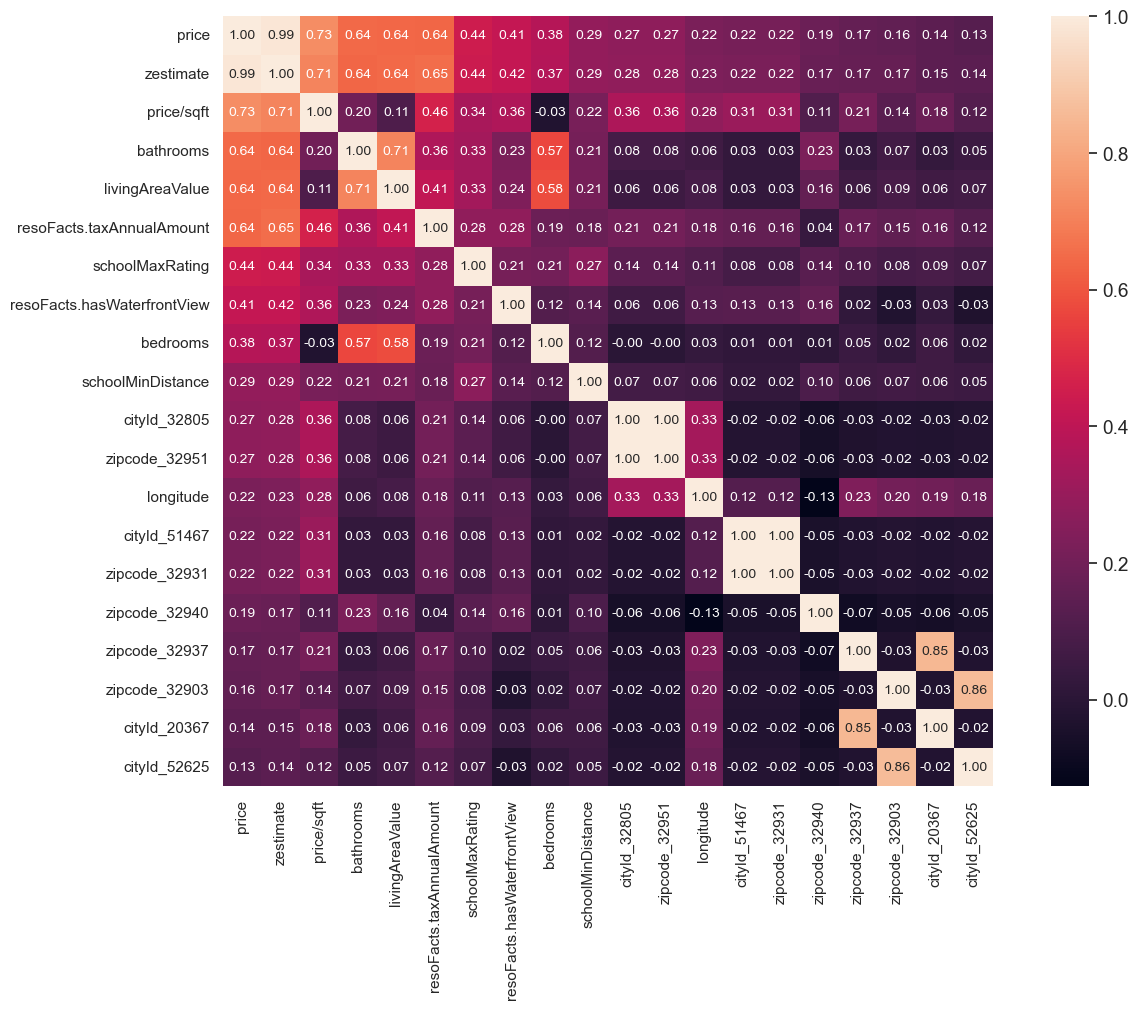

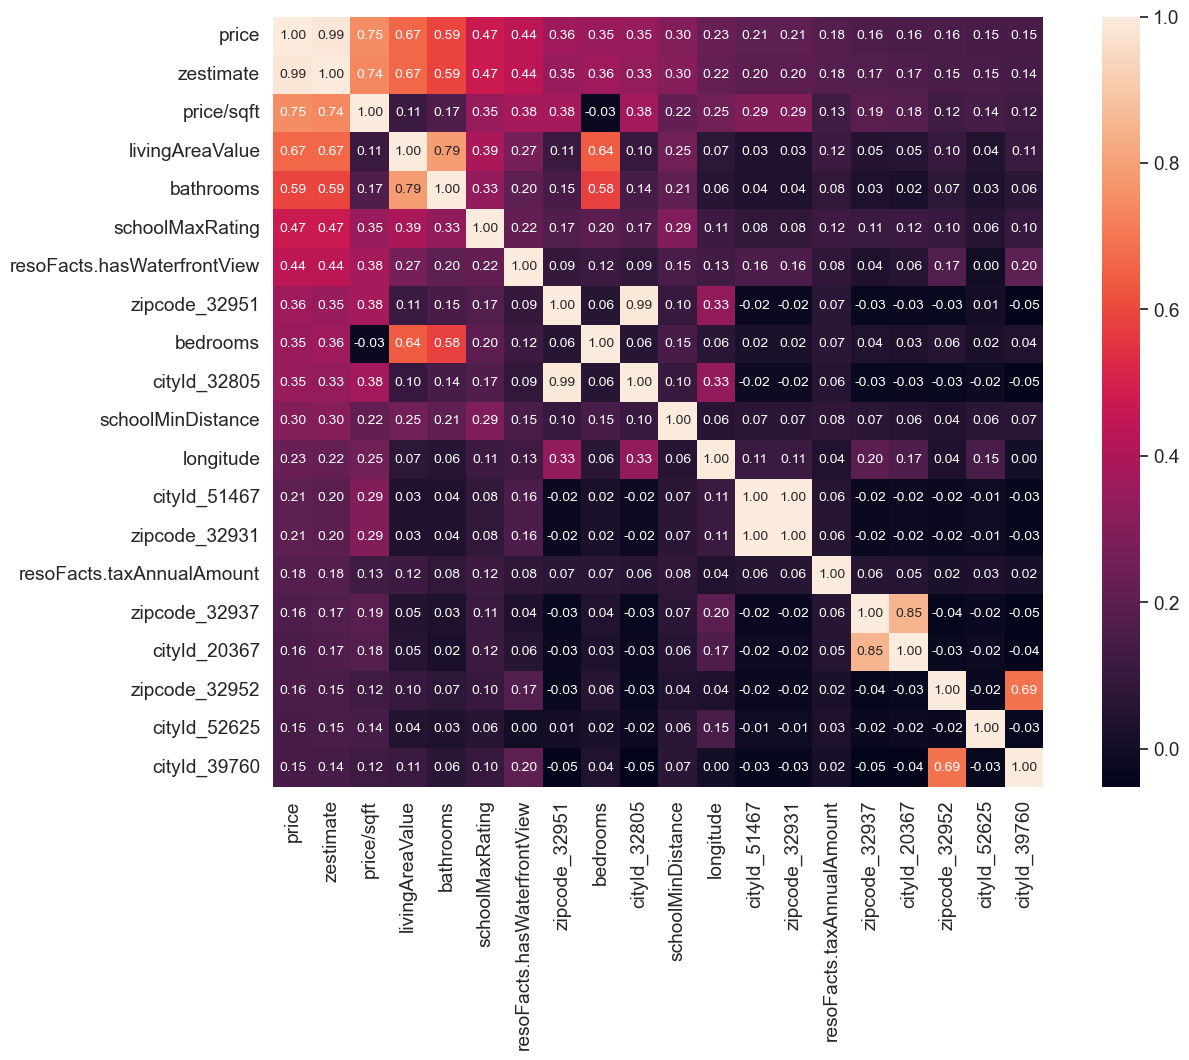

Most Correlated Features - Recently Sold  \
0                                     price   
1                                 zestimate   
2                                price/sqft   
3                                 bathrooms   
4                           livingAreaValue   
5                 resoFacts.taxAnnualAmount   
6                           schoolMaxRating   
7               resoFacts.hasWaterfrontView   
8                                  bedrooms   
9                         schoolMinDistance   
10                             cityId_32805   
11                            zipcode_32951   
12                                longitude   
13                             cityId_51467   
14                            zipcode_32931   
15                            zipcode_32940   
16                            zipcode_32937   
17                            zipcode_32903   
18                             cityId_20367   
19                             cityId_52625   

   Most Correlated Features - For Sale  
0                                price  
1                            zestimate  
2                           price/sqft  
3                      livingAreaValue  
4                            bathrooms  
5                      schoolMaxRating  
6          resoFacts.hasWaterfrontView  
7                        zipcode_32951  
8                             bedrooms  
9                         cityId_32805  
10                   schoolMinDistance  
11                           longitude  
12                        cityId_51467  
13                       zipcode_32931  
14           resoFacts.taxAnnualAmount  
15                       zipcode_32937  
16                        cityId_20367  
17                       zipcode_32952  
18                        cityId_52625  
19                        cityId_39760

In [20]:
'''
Checking feature correlations for possible further downselection
'''

# Correlation Matrix Heatmap
corrmat = df_recentlySold_trunc[numCols].corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=False)

# Correlation Heatmap: Top 20 Features
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df_recentlySold_trunc[cols].values.T)
sns.set_theme(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features - Recently Sold']

# Correlation Matrix Heatmap
corrmat = df_forSale_trunc[numCols].corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=False)

# Correlation Heatmap: Top 20 Features
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df_forSale_trunc[cols].values.T)
sns.set_theme(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


most_corr['Most Correlated Features - For Sale'] = cols
most_corr

The order of importance varies between the two data sets. Each of these features will be individually inspected below. For each feature, outliers will be removed.

The zestimate and price/sqft columns will be ignored for now. These are two features which will not be used for model training as they are directly linked to the target variable.

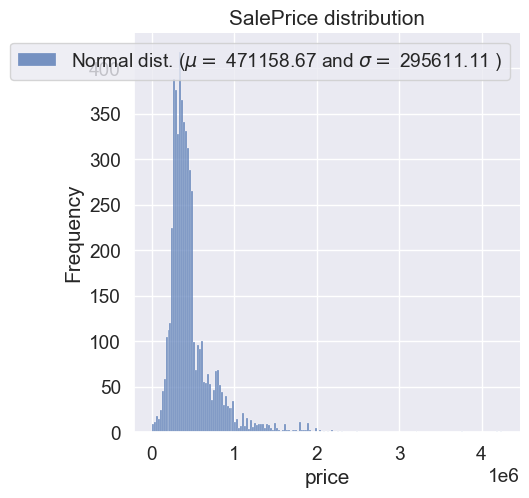

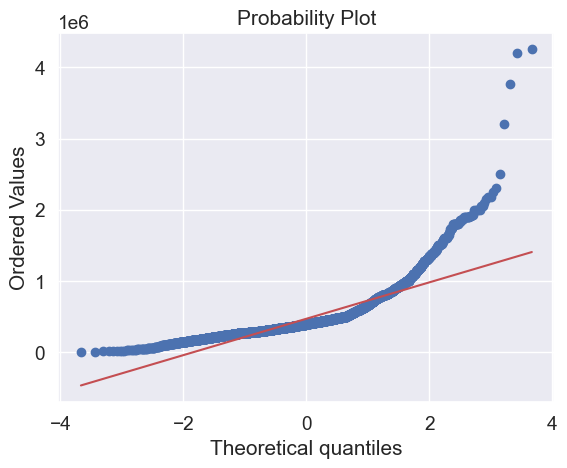

Recently Sold Data:
Skewness: 3.145789
Kurtosis: 19.130281


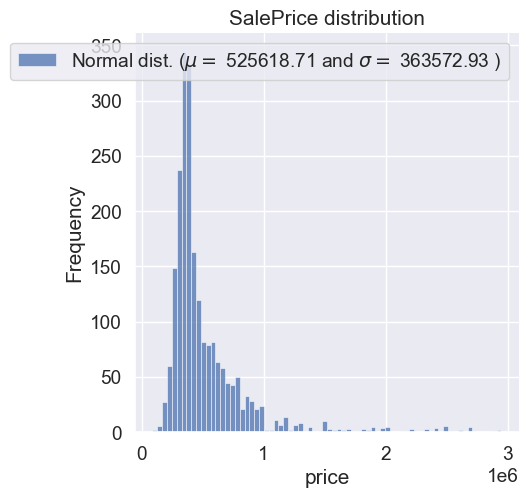

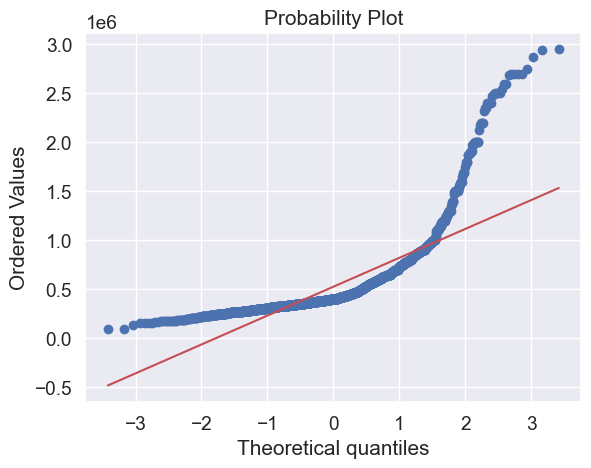

For Sale Data:
Skewness: 3.244607
Kurtosis: 13.280907


In [21]:
'''
Let's look at price distributions
'''

# Plot Histogram
sns.displot(df_recentlySold_trunc['price'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_recentlySold_trunc['price'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(df_recentlySold_trunc['price'], plot=plt)
plt.show()
print('Recently Sold Data:')
print('Skewness: %f' % df_recentlySold_trunc['price'].skew()) # <-- Measure of lack of left-to-right symmetry. High vale = less symmetric
print('Kurtosis: %f' % df_recentlySold_trunc['price'].kurt()) # <-- Measure of heavy tailed or lightly tailed. High value = heavy tail

'''
Details on skewness and kurtosis:
https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm
'''


# Plot Histogram
sns.displot(df_forSale_trunc['price'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_forSale_trunc['price'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(df_forSale_trunc['price'], plot=plt)
plt.show()
print('For Sale Data:')
print('Skewness: %f' % df_forSale_trunc['price'].skew())
print('Kurtosis: %f' % df_forSale_trunc['price'].kurt())

The price data is similary skewed across the two datasets. We will adjust this later.

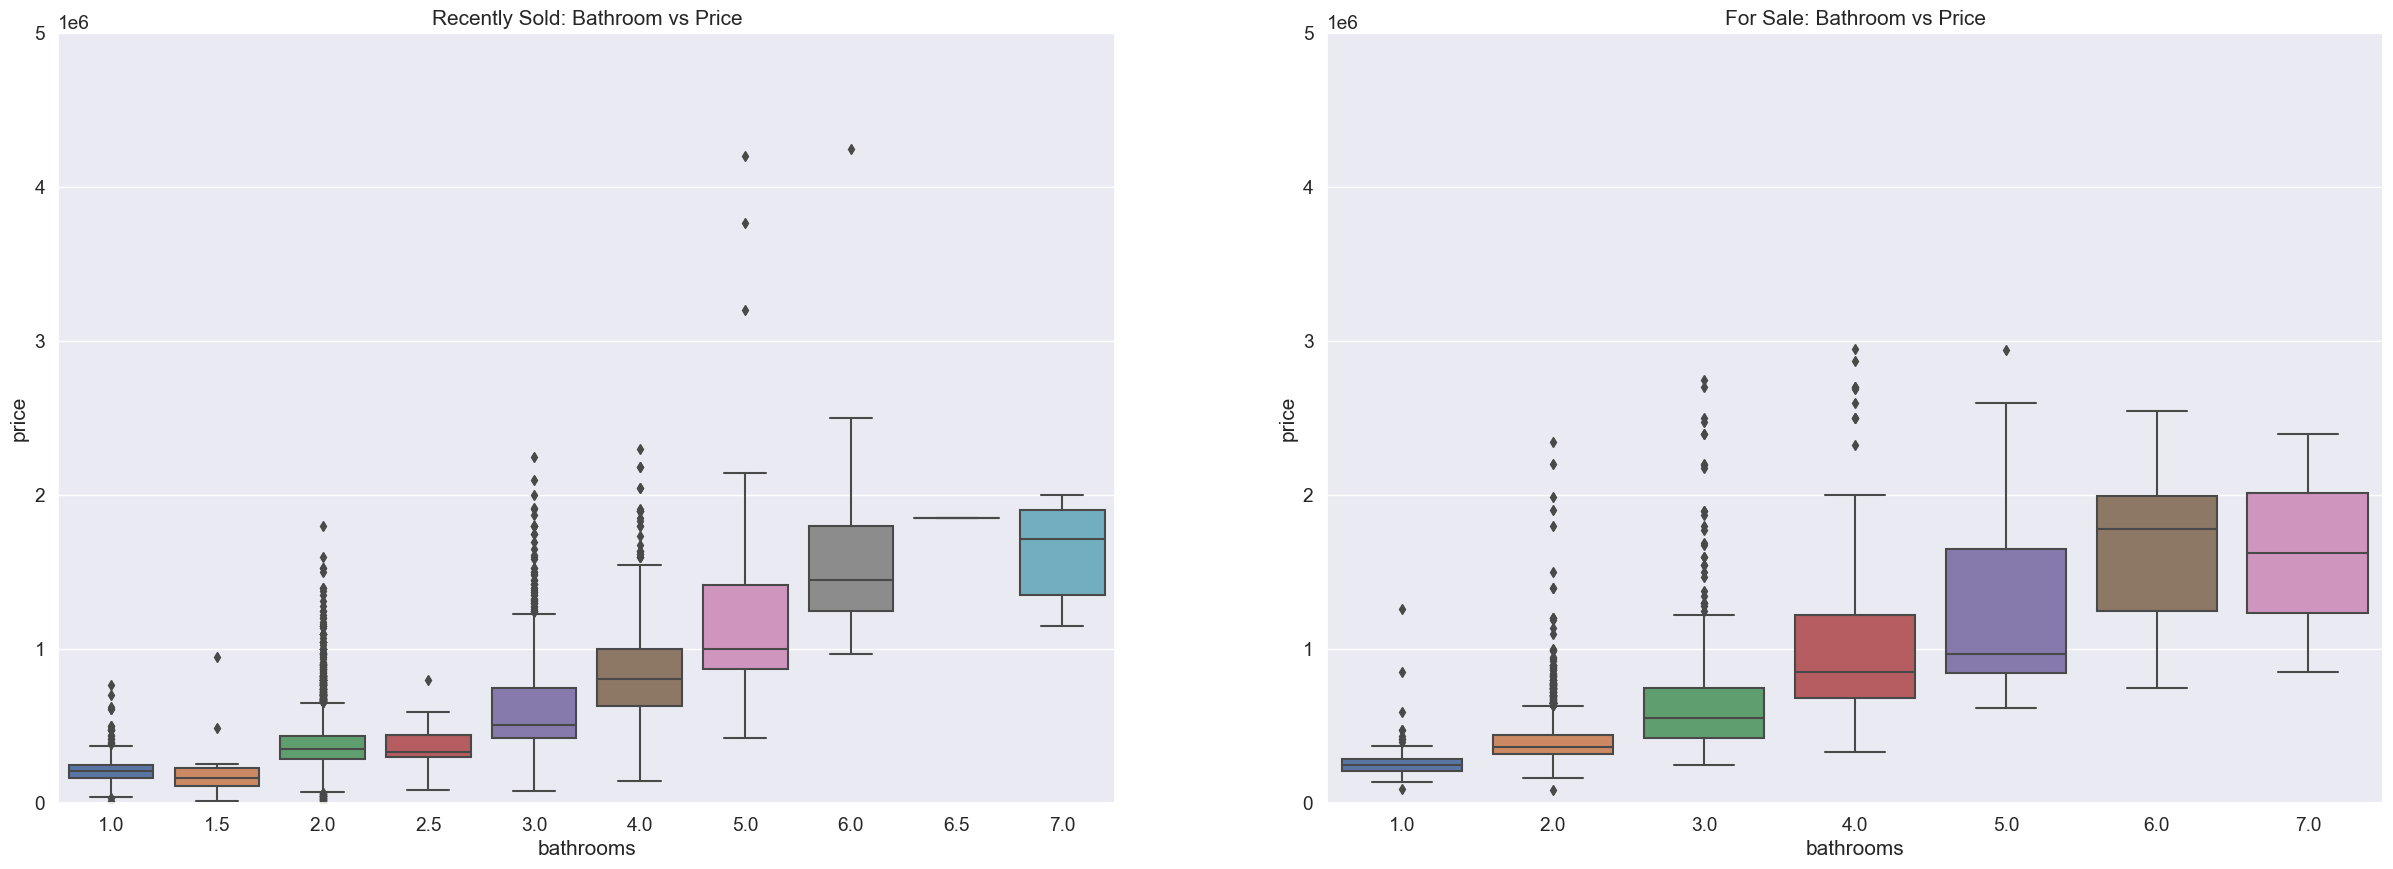

In [22]:
'''
Bathroom vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['bathrooms']==0].index).reset_index(drop=True)
df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['bathrooms']==3.5].index).reset_index(drop=True)
df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[(df_recentlySold_trunc['bathrooms']>2) & (df_recentlySold_trunc['bathrooms']<2.1)].index).reset_index(drop=True)
df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[df_forSale_trunc['bathrooms']>=8].index).reset_index(drop=True)

var = 'bathrooms'
f, ax = plt.subplots(1,2,figsize=(30, 10))
data = pd.concat([df_recentlySold_trunc['price'], df_recentlySold_trunc[var]], axis=1)
sns.boxplot(x=var, y="price", data=data, ax=ax[0])
data = pd.concat([df_forSale_trunc['price'], df_forSale_trunc[var]], axis=1)
fig = sns.boxplot(x=var, y="price", data=data, ax=ax[1])
plt.setp(ax[0], ylim=[0, 5e6])
plt.setp(ax[1], ylim=[0, 5e6])
ax[0].title.set_text('Recently Sold: Bathroom vs Price')
ax[1].title.set_text('For Sale: Bathroom vs Price')
plt.show()

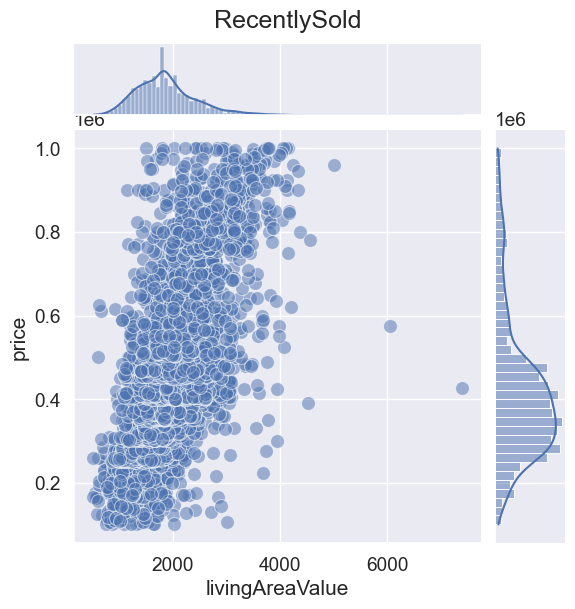

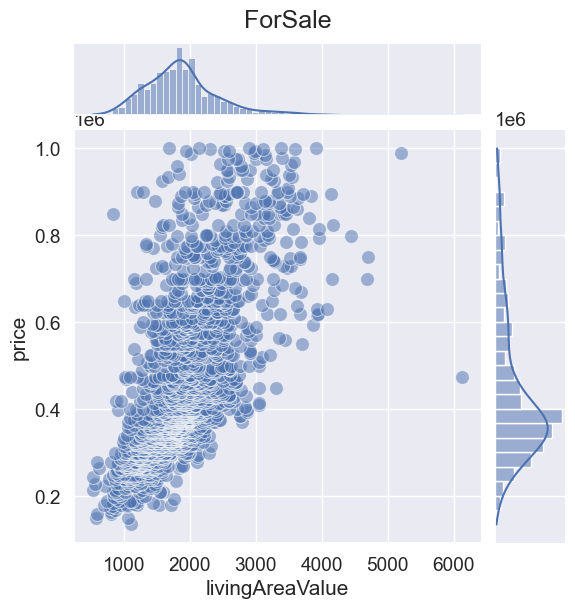

In [23]:
'''
Living Area Value vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['livingAreaValue']>5000].index).reset_index(drop=True)
df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[df_forSale_trunc['livingAreaValue']>5000].index).reset_index(drop=True)

df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['price']>1e6].index).reset_index(drop=True)
df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[df_forSale_trunc['price']>1e6].index).reset_index(drop=True)

df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['price']<1e5].index).reset_index(drop=True)
df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[df_forSale_trunc['price']<1e5].index).reset_index(drop=True)



var = 'livingAreaValue'
g1 = sns.JointGrid(data=df_recentlySold_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('RecentlySold', y=1.02)
plt.show()

g1 = sns.JointGrid(data=df_forSale_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('ForSale', y=1.02)
plt.show()

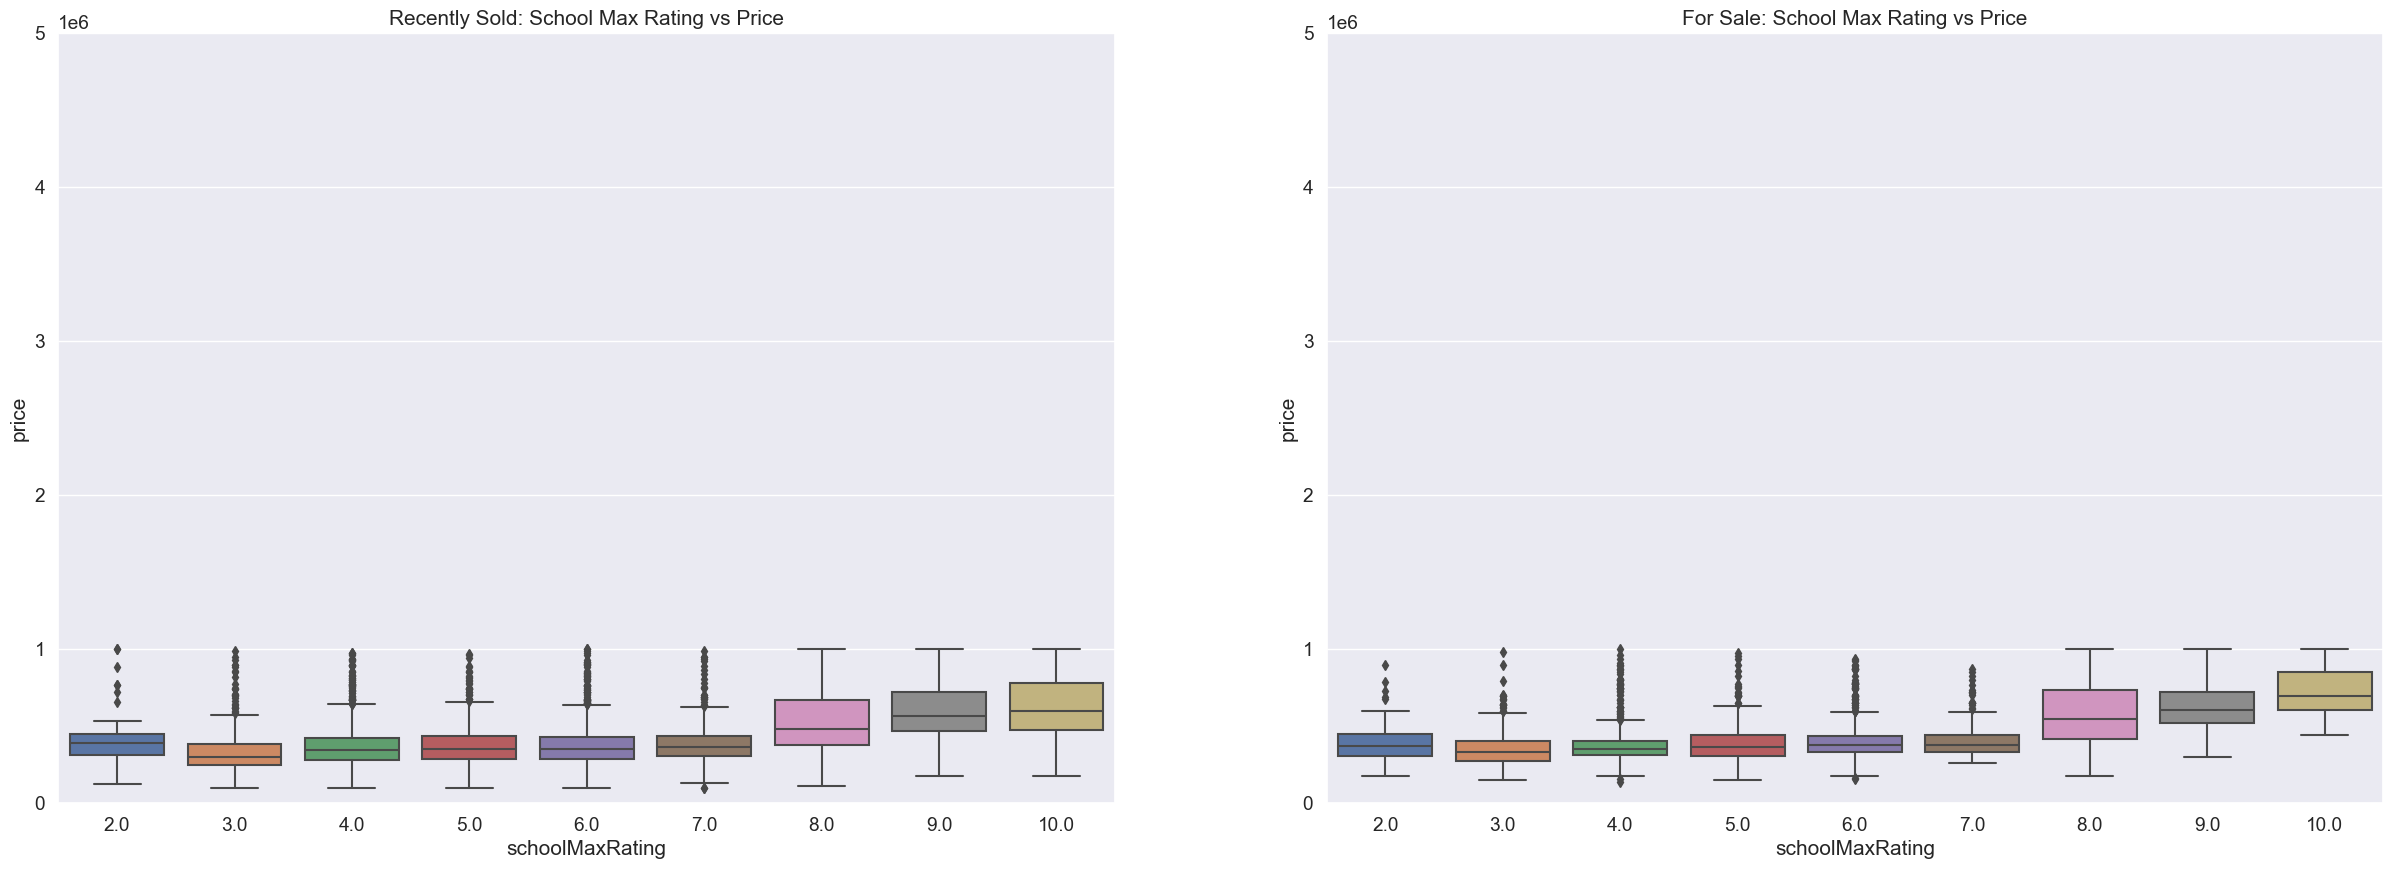

In [24]:
'''
School Max Rating vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
# df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['bathrooms']==0].index).reset_index(drop=True)

var = 'schoolMaxRating'
f, ax = plt.subplots(1,2,figsize=(30, 10))
data = pd.concat([df_recentlySold_trunc['price'], df_recentlySold_trunc[var]], axis=1)
sns.boxplot(x=var, y="price", data=data, ax=ax[0])
data = pd.concat([df_forSale_trunc['price'], df_forSale_trunc[var]], axis=1)
fig = sns.boxplot(x=var, y="price", data=data, ax=ax[1])
plt.setp(ax[0], ylim=[0, 5e6])
plt.setp(ax[1], ylim=[0, 5e6])
ax[0].title.set_text('Recently Sold: School Max Rating vs Price')
ax[1].title.set_text('For Sale: School Max Rating vs Price')
plt.show()

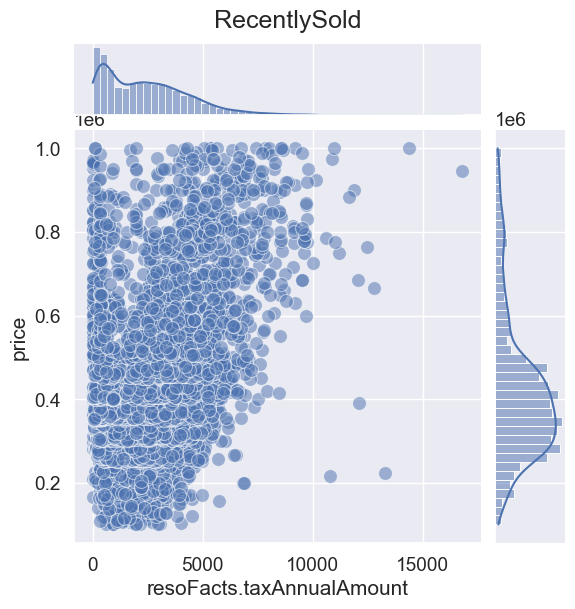

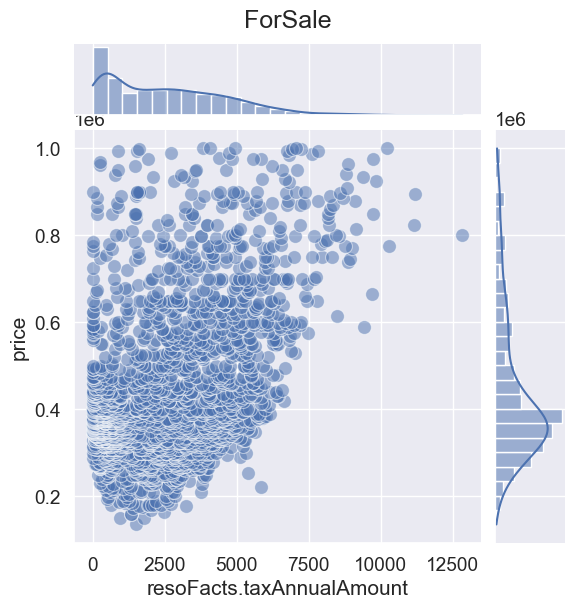

In [25]:
'''
Annual Tax Amount vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['resoFacts.taxAnnualAmount']>30000].index).reset_index(drop=True)
df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[df_forSale_trunc['resoFacts.taxAnnualAmount']>100000].index).reset_index(drop=True)

var = 'resoFacts.taxAnnualAmount'
g1 = sns.JointGrid(data=df_recentlySold_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('RecentlySold', y=1.02)
plt.show()

g1 = sns.JointGrid(data=df_forSale_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('ForSale', y=1.02)
plt.show()

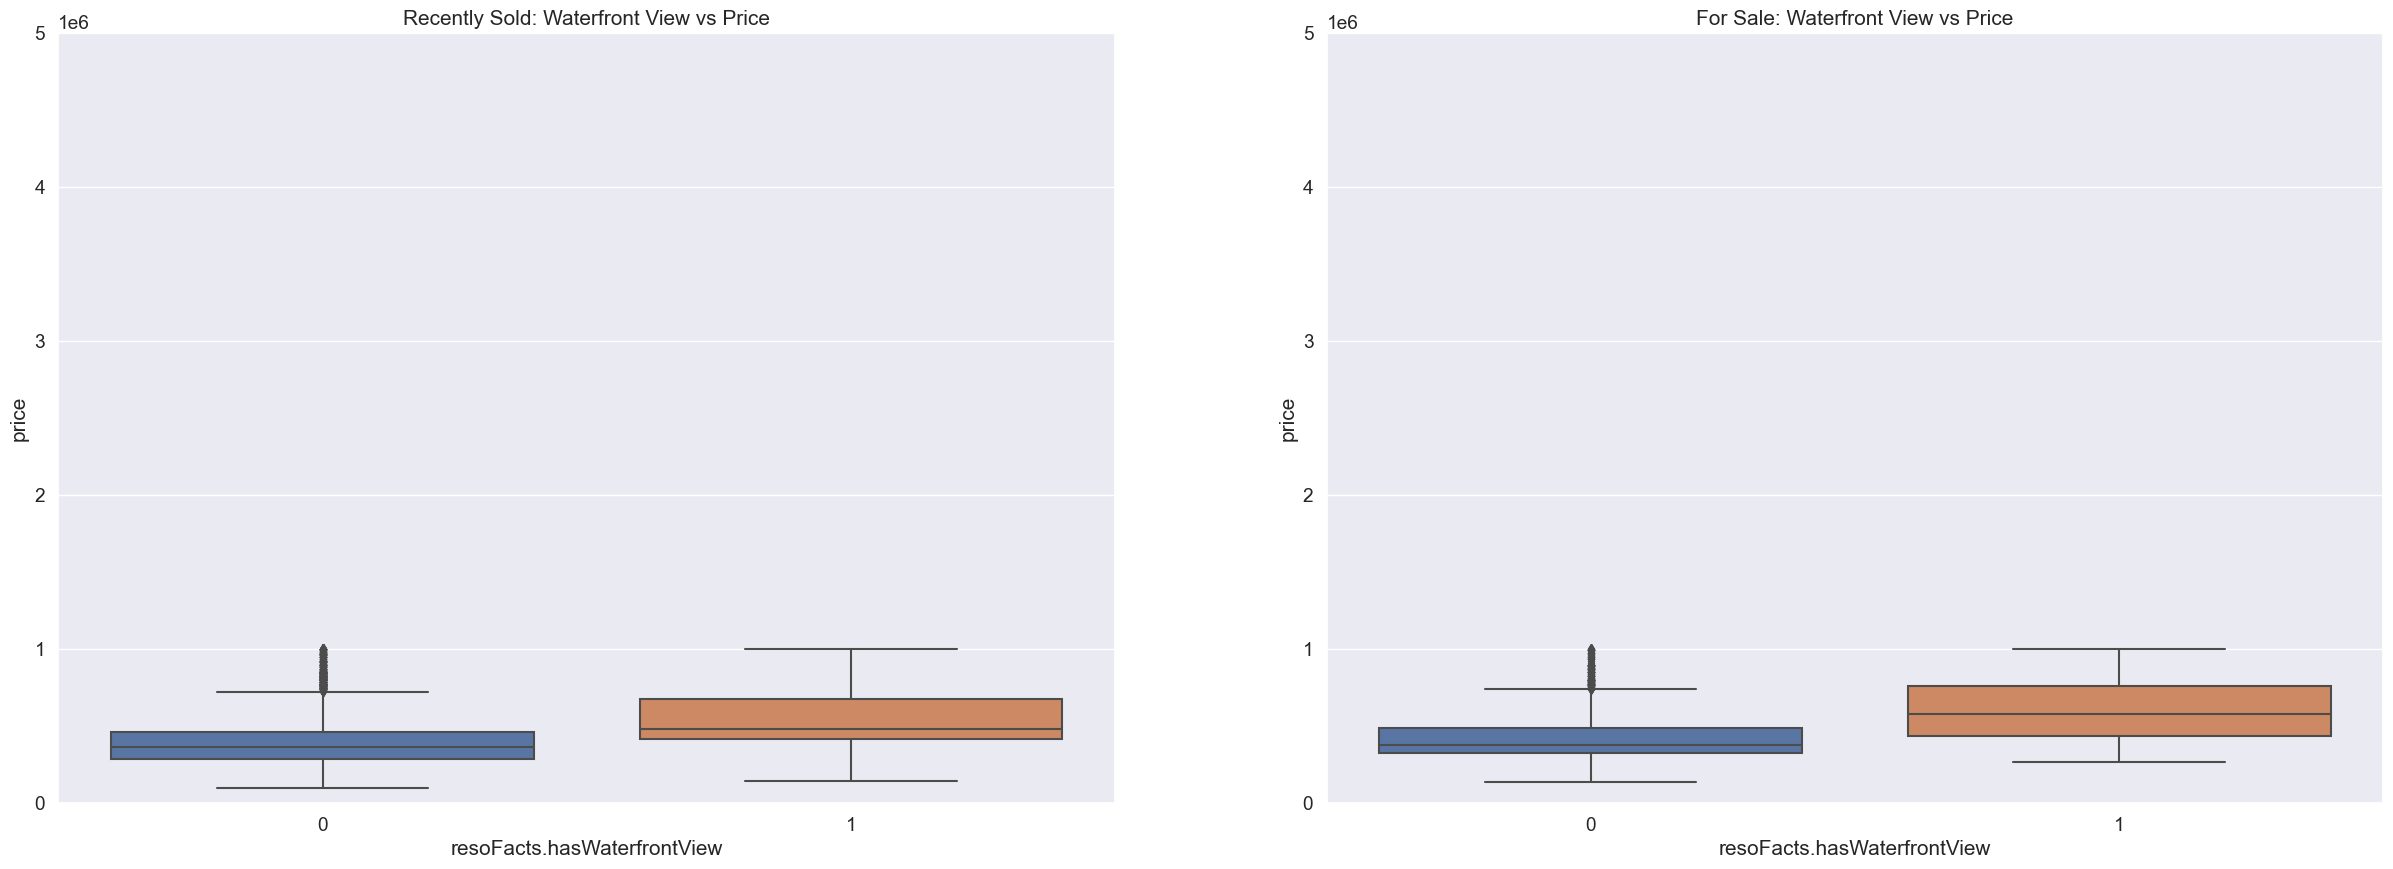

In [26]:
'''
Waterfront View vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
# df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['bathrooms']==0].index).reset_index(drop=True)

var = 'resoFacts.hasWaterfrontView'
f, ax = plt.subplots(1,2,figsize=(30, 10))
data = pd.concat([df_recentlySold_trunc['price'], df_recentlySold_trunc[var]], axis=1)
sns.boxplot(x=var, y="price", data=data, ax=ax[0])
data = pd.concat([df_forSale_trunc['price'], df_forSale_trunc[var]], axis=1)
fig = sns.boxplot(x=var, y="price", data=data, ax=ax[1])
plt.setp(ax[0], ylim=[0, 5e6])
plt.setp(ax[1], ylim=[0, 5e6])
ax[0].title.set_text('Recently Sold: Waterfront View vs Price')
ax[1].title.set_text('For Sale: Waterfront View vs Price')
plt.show()

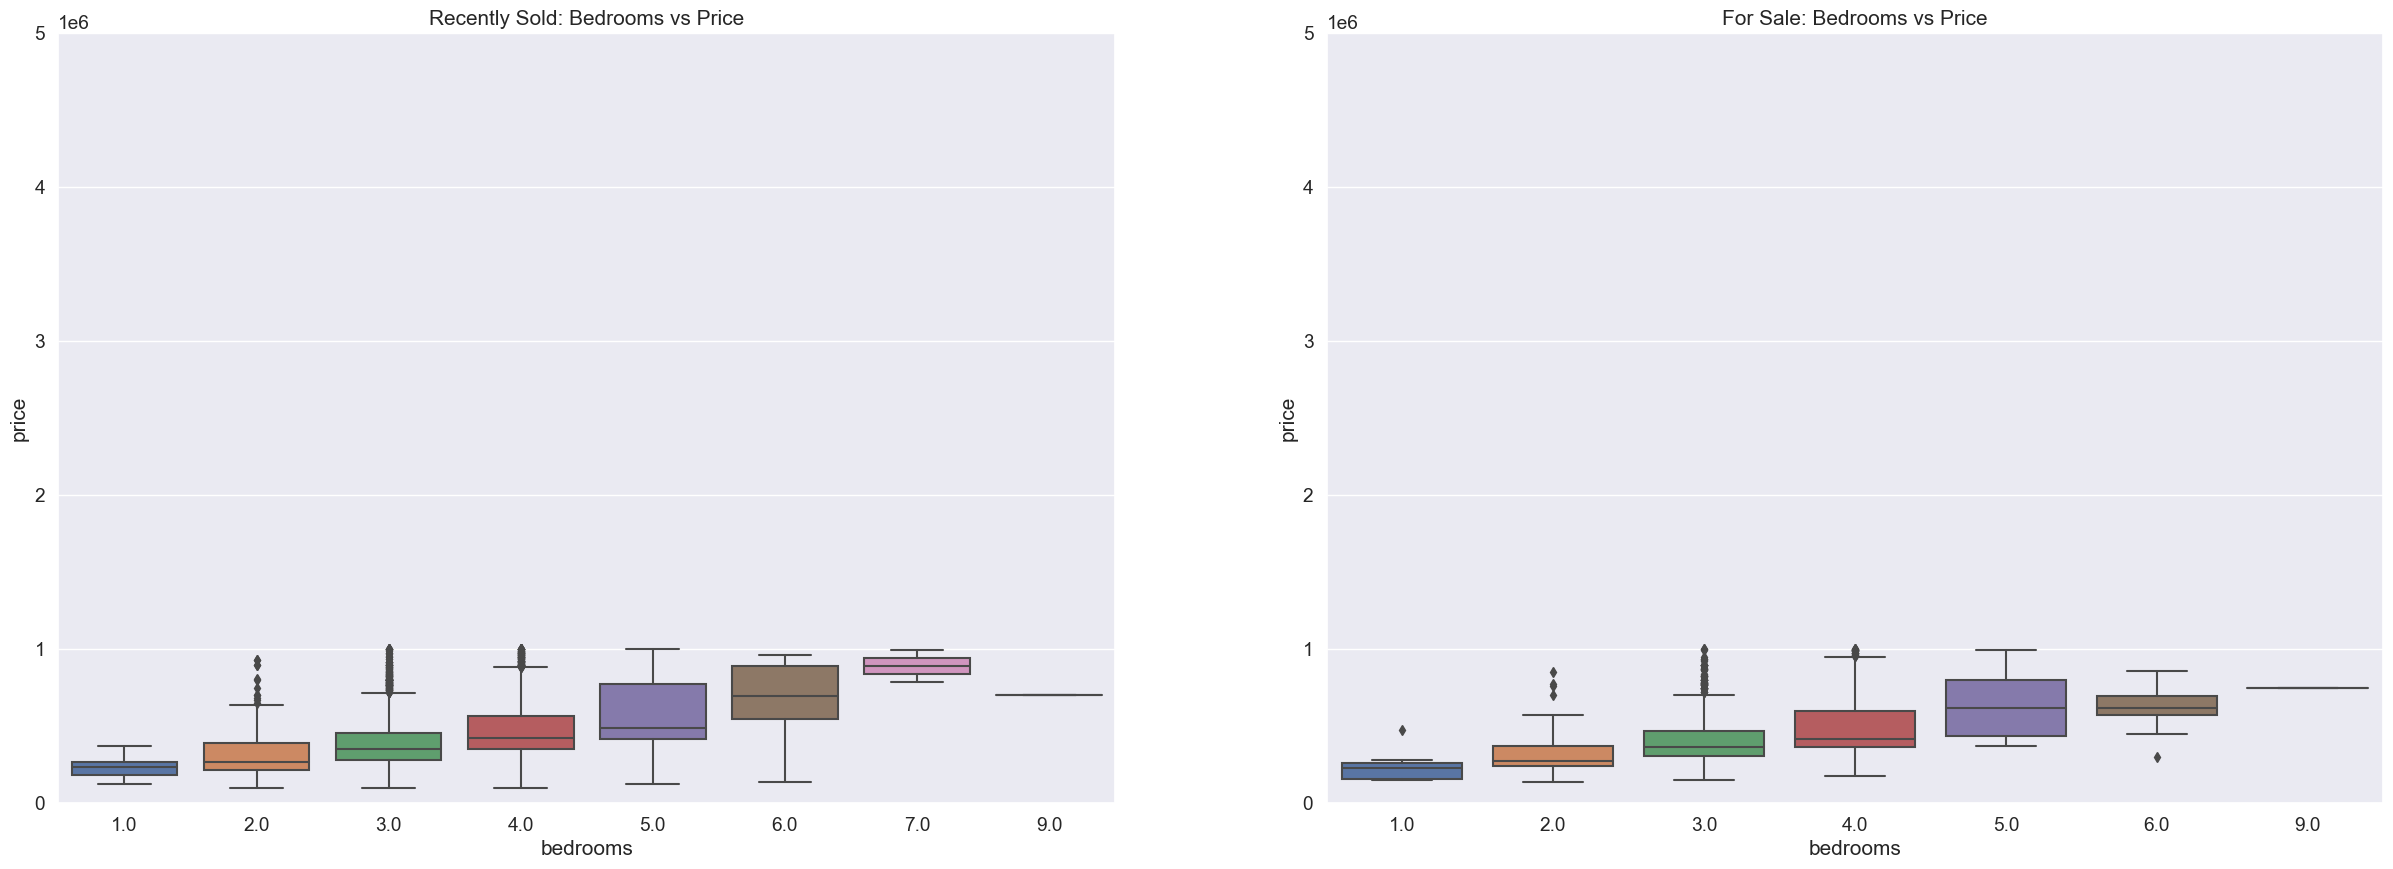

In [27]:
'''
Bedrooms vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['bedrooms']==0].index).reset_index(drop=True)
df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[df_forSale_trunc['bedrooms']==0].index).reset_index(drop=True)

var = 'bedrooms'
f, ax = plt.subplots(1,2,figsize=(30, 10))
data = pd.concat([df_recentlySold_trunc['price'], df_recentlySold_trunc[var]], axis=1)
sns.boxplot(x=var, y="price", data=data, ax=ax[0])
data = pd.concat([df_forSale_trunc['price'], df_forSale_trunc[var]], axis=1)
fig = sns.boxplot(x=var, y="price", data=data, ax=ax[1])
plt.setp(ax[0], ylim=[0, 5e6])
plt.setp(ax[1], ylim=[0, 5e6])
ax[0].title.set_text('Recently Sold: Bedrooms vs Price')
ax[1].title.set_text('For Sale: Bedrooms vs Price')
plt.show()

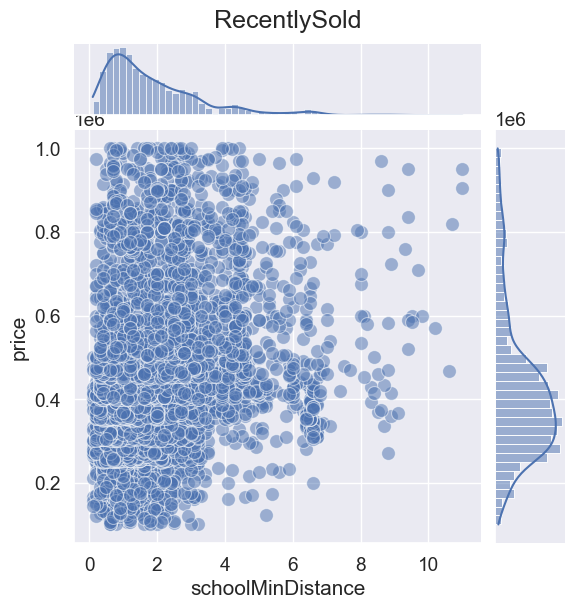

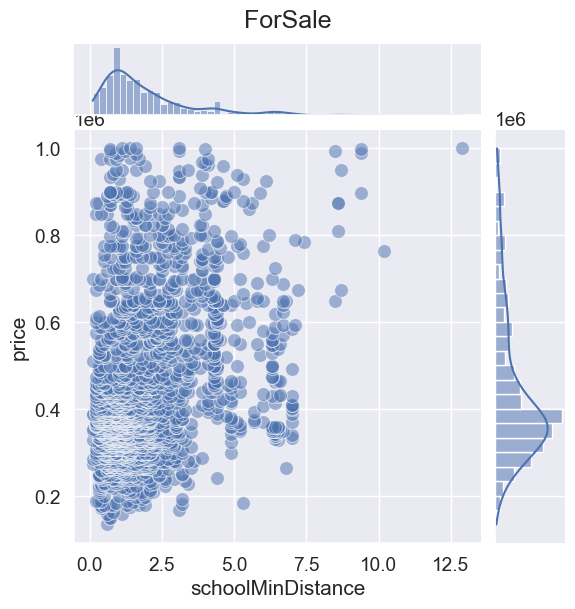

In [28]:
'''
Min Distance to School vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
# df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['resoFacts.taxAnnualAmount']>30000].index).reset_index(drop=True)

var = 'schoolMinDistance'
g1 = sns.JointGrid(data=df_recentlySold_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('RecentlySold', y=1.02)
plt.show()

g1 = sns.JointGrid(data=df_forSale_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('ForSale', y=1.02)
plt.show()

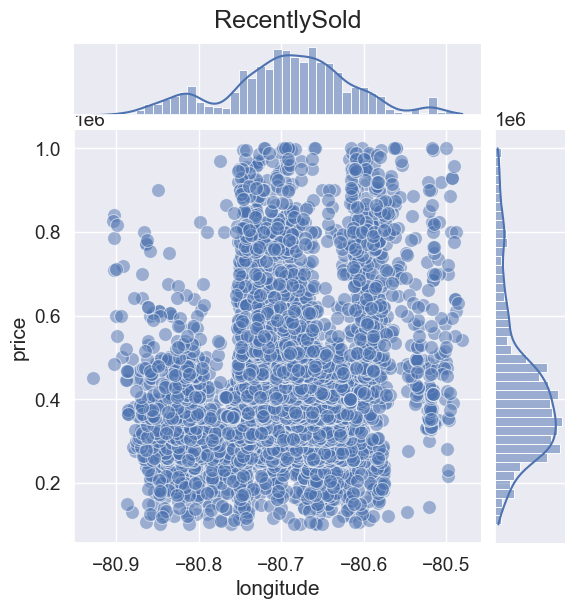

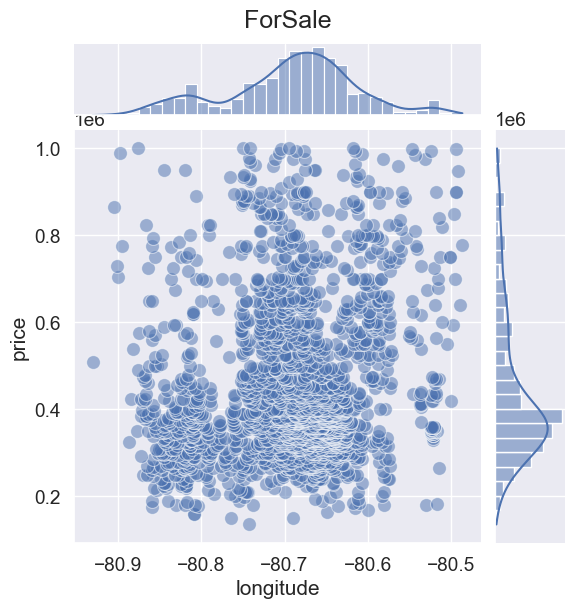

In [29]:
'''
Longitude vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
# df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['resoFacts.taxAnnualAmount']>30000].index).reset_index(drop=True)

var = 'longitude'
g1 = sns.JointGrid(data=df_recentlySold_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('RecentlySold', y=1.02)
plt.show()

g1 = sns.JointGrid(data=df_forSale_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('ForSale', y=1.02)
plt.show()

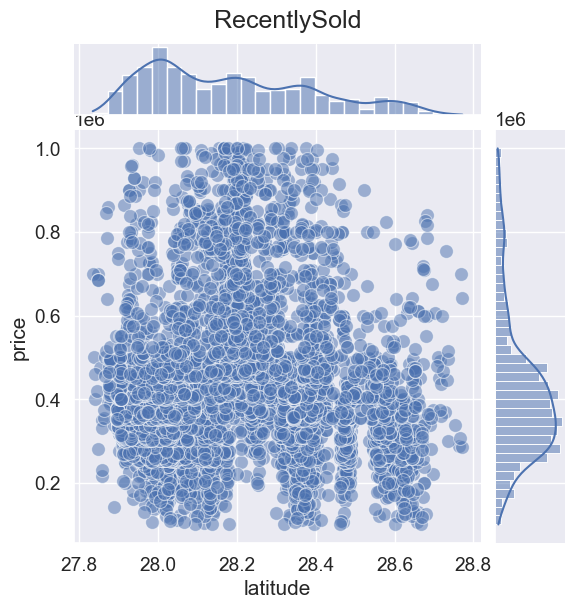

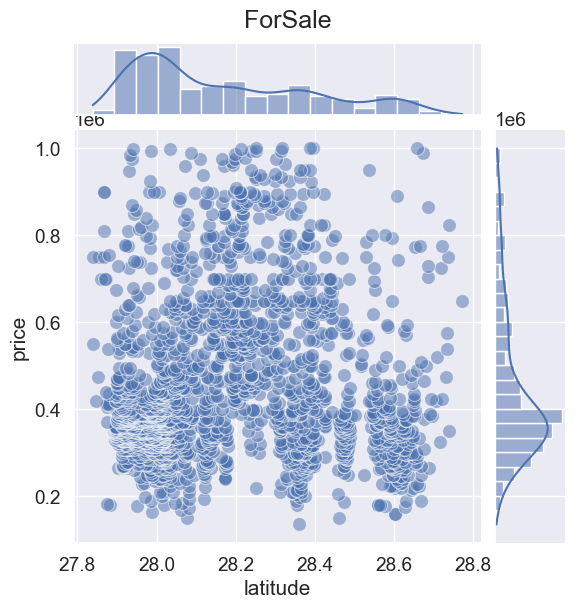

In [30]:
'''
Latitude vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[(df_recentlySold_trunc['latitude']>28.7) & (df_recentlySold_trunc['price']>1e6)].index).reset_index(drop=True)
df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[(df_forSale_trunc['latitude']>28.7) & (df_forSale_trunc['price']>1e6)].index).reset_index(drop=True)

var = 'latitude'
g1 = sns.JointGrid(data=df_recentlySold_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('RecentlySold', y=1.02)
plt.show()

g1 = sns.JointGrid(data=df_forSale_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('ForSale', y=1.02)
plt.show()

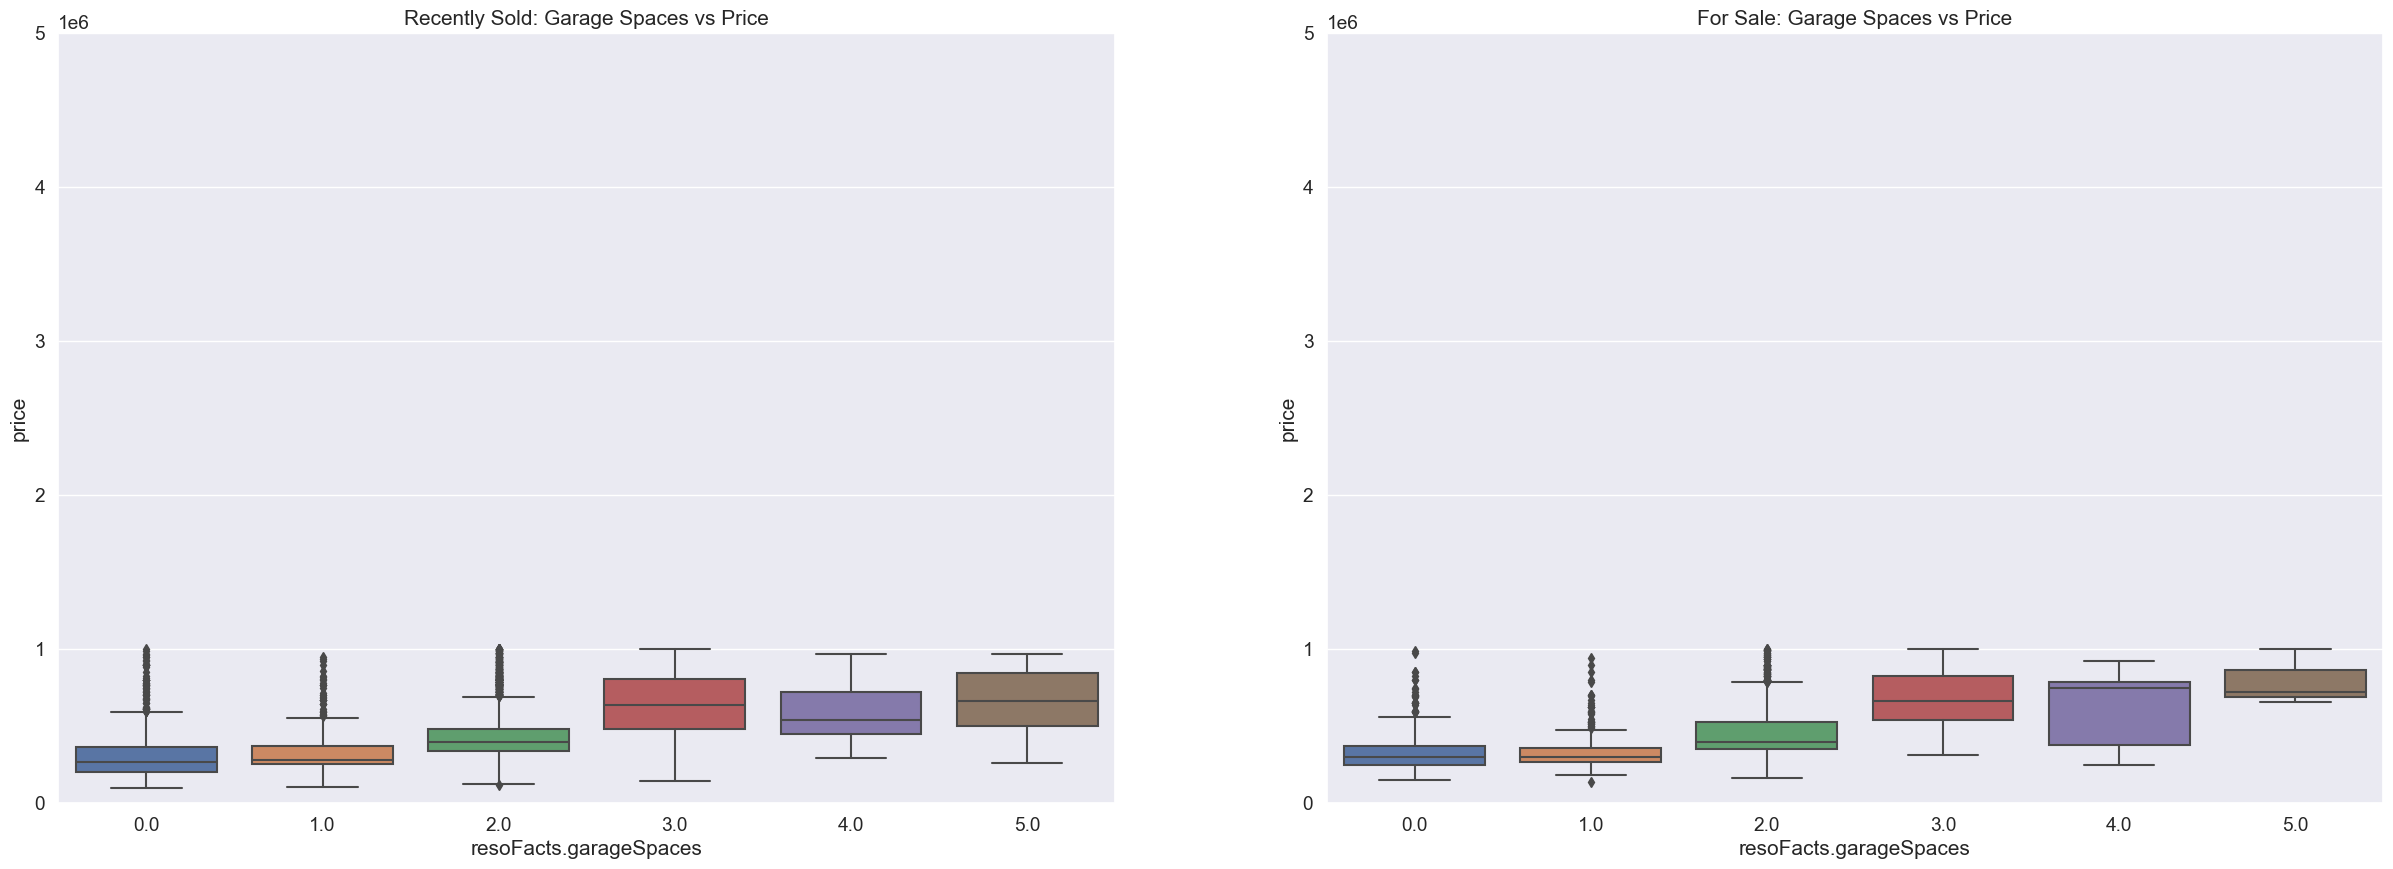

In [31]:
'''
Garage Spaces vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['resoFacts.garageSpaces']>5].index).reset_index(drop=True)
df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[df_forSale_trunc['resoFacts.garageSpaces']>5].index).reset_index(drop=True)

var = 'resoFacts.garageSpaces'
f, ax = plt.subplots(1,2,figsize=(30, 10))
data = pd.concat([df_recentlySold_trunc['price'], df_recentlySold_trunc[var]], axis=1)
sns.boxplot(x=var, y="price", data=data, ax=ax[0])
data = pd.concat([df_forSale_trunc['price'], df_forSale_trunc[var]], axis=1)
fig = sns.boxplot(x=var, y="price", data=data, ax=ax[1])
plt.setp(ax[0], ylim=[0, 5e6])
plt.setp(ax[1], ylim=[0, 5e6])
ax[0].title.set_text('Recently Sold: Garage Spaces vs Price')
ax[1].title.set_text('For Sale: Garage Spaces vs Price')
plt.show()

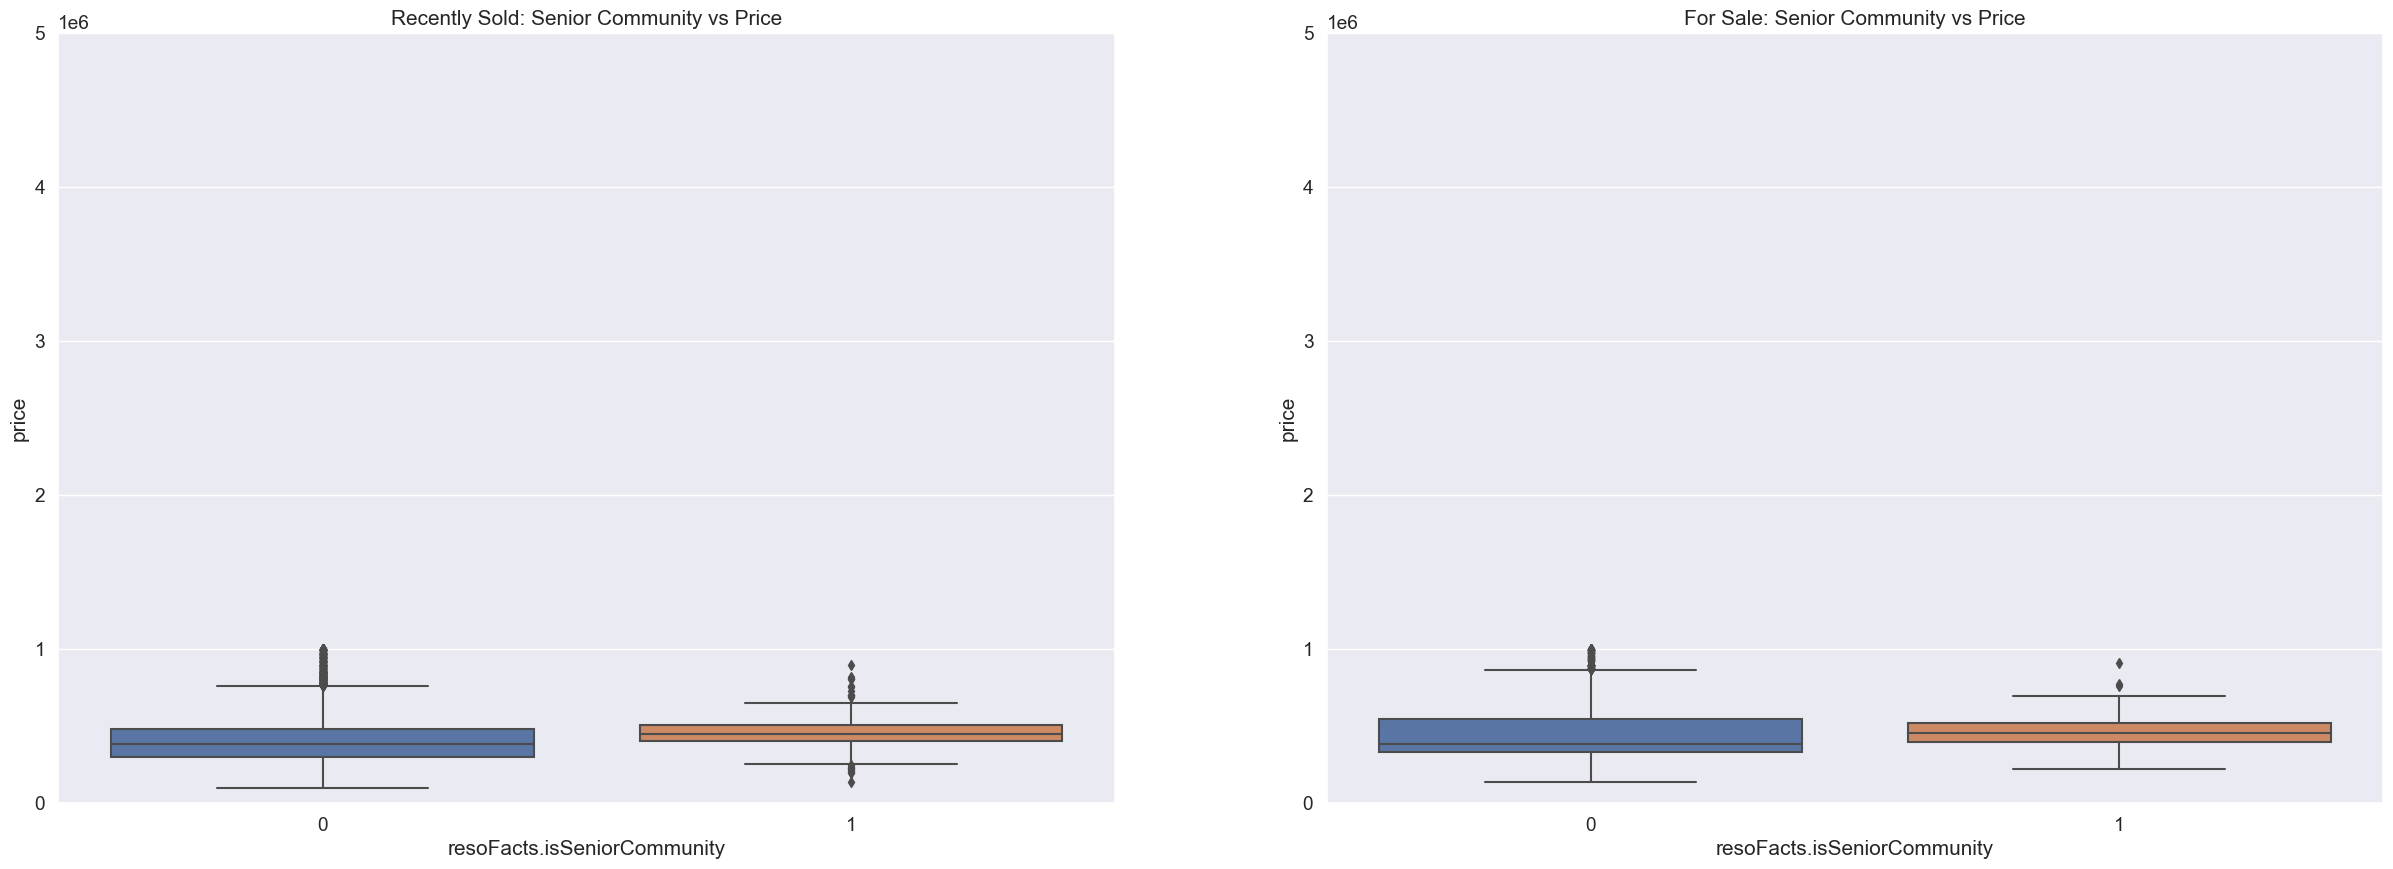

In [32]:
'''
Senior Community vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
# df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['resoFacts.garageSpaces']>5].index).reset_index(drop=True)
# df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[df_forSale_trunc['resoFacts.garageSpaces']>5].index).reset_index(drop=True)

var = 'resoFacts.isSeniorCommunity'
f, ax = plt.subplots(1,2,figsize=(30, 10))
data = pd.concat([df_recentlySold_trunc['price'], df_recentlySold_trunc[var]], axis=1)
sns.boxplot(x=var, y="price", data=data, ax=ax[0])
data = pd.concat([df_forSale_trunc['price'], df_forSale_trunc[var]], axis=1)
fig = sns.boxplot(x=var, y="price", data=data, ax=ax[1])
plt.setp(ax[0], ylim=[0, 5e6])
plt.setp(ax[1], ylim=[0, 5e6])
ax[0].title.set_text('Recently Sold: Senior Community vs Price')
ax[1].title.set_text('For Sale: Senior Community vs Price')
plt.show()

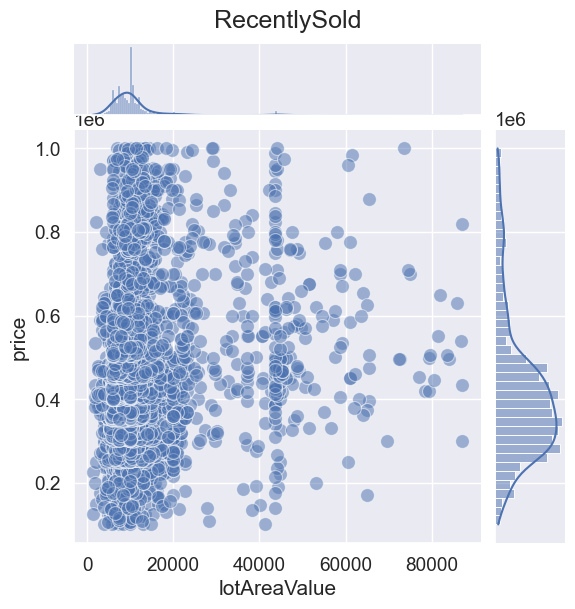

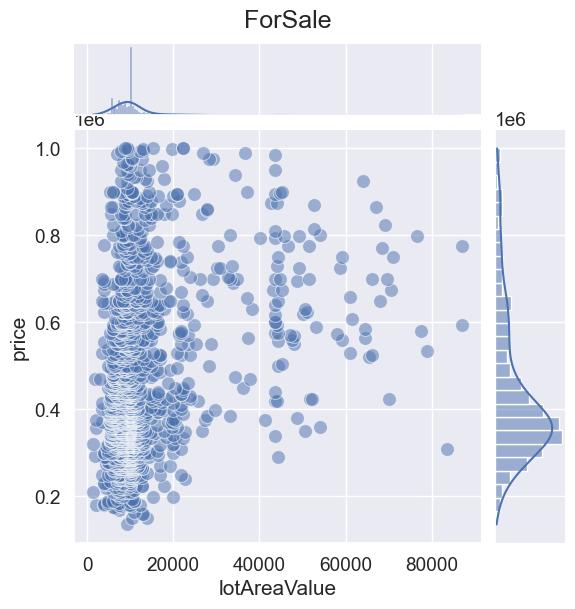

In [33]:
'''
Lot Area Value vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['lotAreaValue']>87120].index).reset_index(drop=True)
df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[df_forSale_trunc['lotAreaValue']>87120].index).reset_index(drop=True)

df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['lotAreaValue']<1000].index).reset_index(drop=True)
df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[df_forSale_trunc['lotAreaValue']<1000].index).reset_index(drop=True)

var = 'lotAreaValue'
g1 = sns.JointGrid(data=df_recentlySold_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('RecentlySold', y=1.02)
plt.show()

# fig, ax = plt.subplots(1,2,figsize=(30, 10))
# sns.scatterplot(data=df_recentlySold_trunc, x=var, y='price', ax=ax[0])
# sns.scatterplot(data=df_forSale_trunc, x=var, y='price', ax=ax[1])

g1 = sns.JointGrid(data=df_forSale_trunc, x=var, y='price')
g1.plot_joint(sns.scatterplot, s=100, alpha=.5)
g1.plot_marginals(sns.histplot, kde=True)
g1.set_axis_labels(xlabel=var, ylabel='price')
g1.figure.suptitle('ForSale', y=1.02)
plt.show()

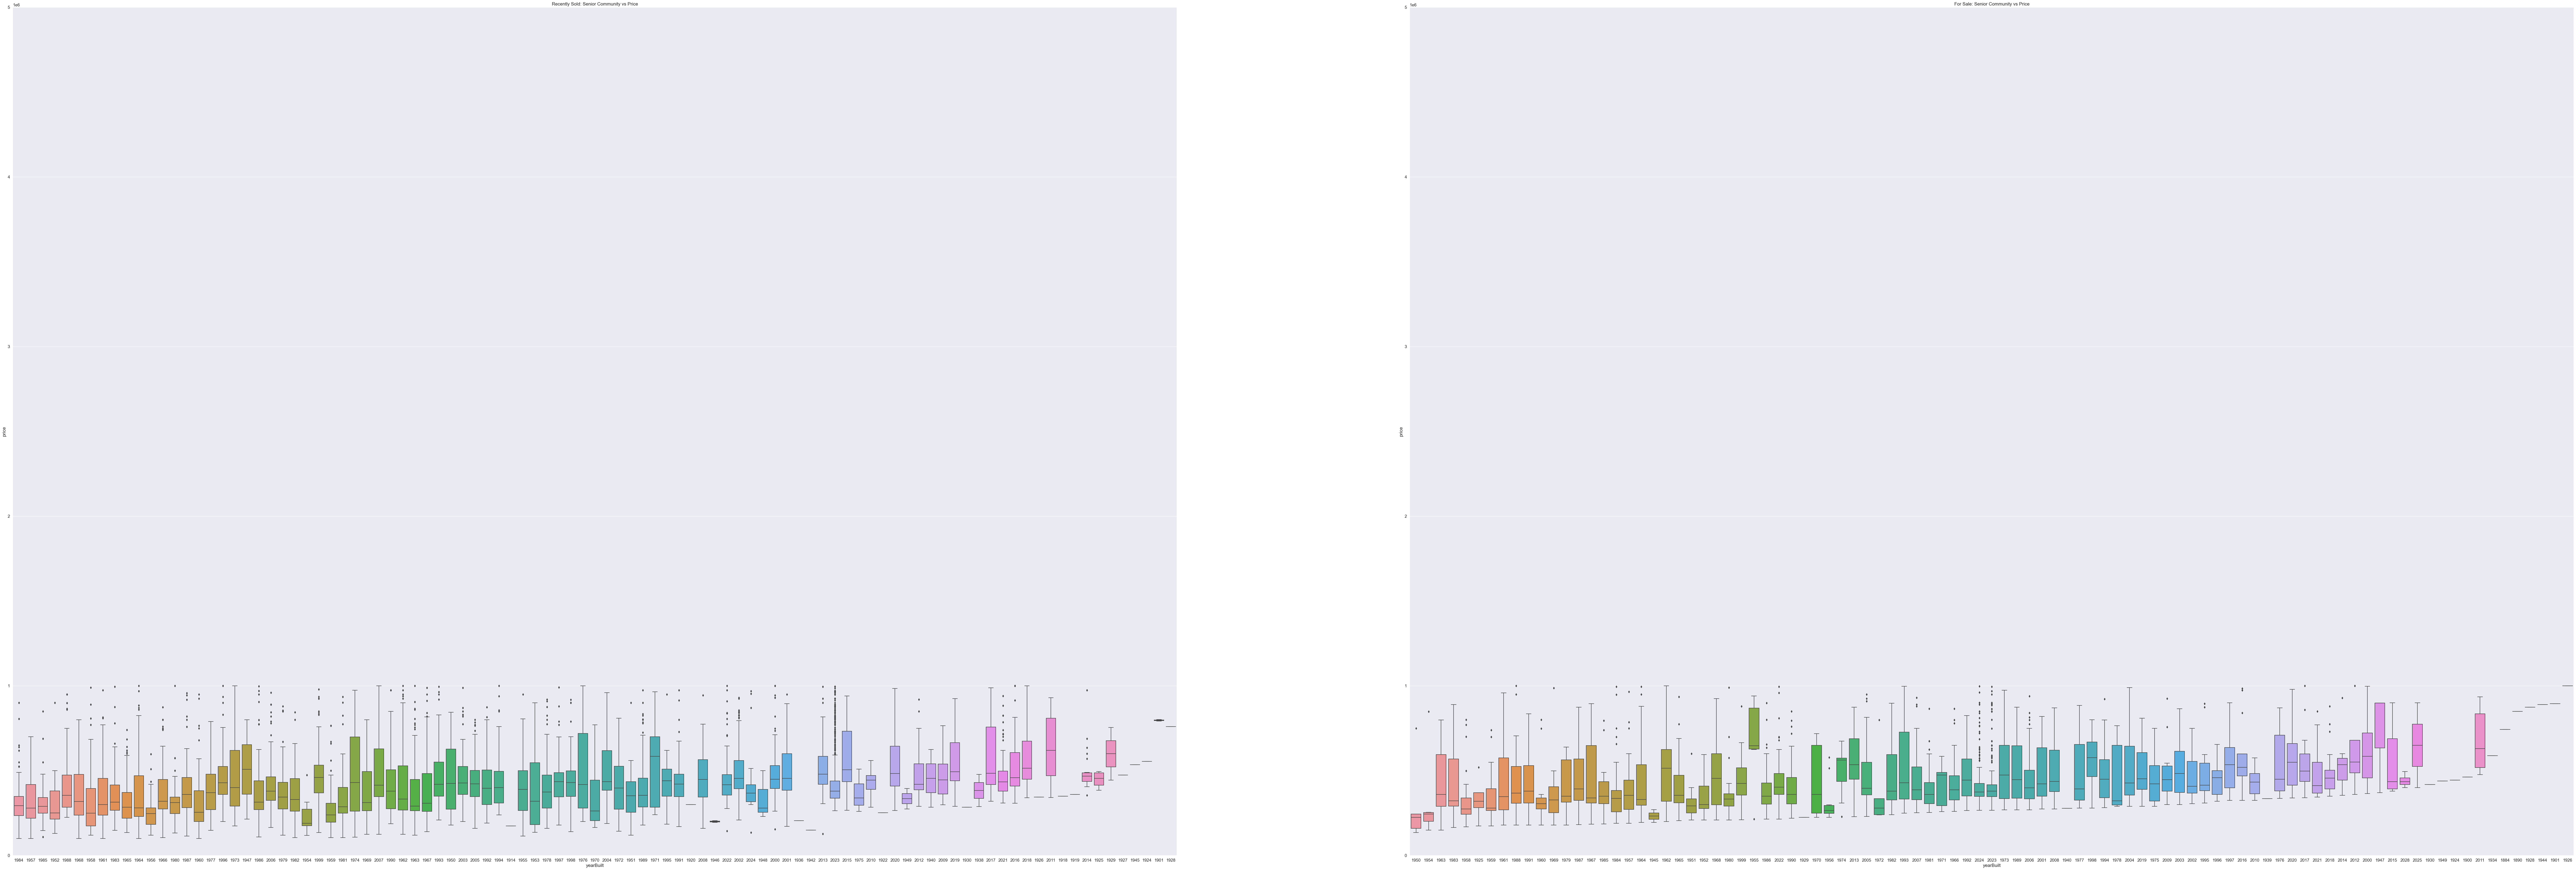

In [34]:
'''
Year Built vs Price
'''

# Comment this section out before running for the first time. Then adjust accordingly, uncomment, and rerun.
# df_recentlySold_trunc = df_recentlySold_trunc.drop(df_recentlySold_trunc[df_recentlySold_trunc['resoFacts.garageSpaces']>5].index).reset_index(drop=True)
# df_forSale_trunc = df_forSale_trunc.drop(df_forSale_trunc[df_forSale_trunc['resoFacts.garageSpaces']>5].index).reset_index(drop=True)

var = 'yearBuilt'
f, ax = plt.subplots(1,2,figsize=(150, 50))
data = pd.concat([df_recentlySold_trunc['price'], df_recentlySold_trunc[var]], axis=1)
sns.boxplot(x=var, y="price", data=data, ax=ax[0])
data = pd.concat([df_forSale_trunc['price'], df_forSale_trunc[var]], axis=1)
sns.boxplot(x=var, y="price", data=data, ax=ax[1])
plt.setp(ax[0], ylim=[0, 5e6])
plt.setp(ax[1], ylim=[0, 5e6])
ax[0].title.set_text('Recently Sold: Senior Community vs Price')
ax[1].title.set_text('For Sale: Senior Community vs Price')
plt.show()

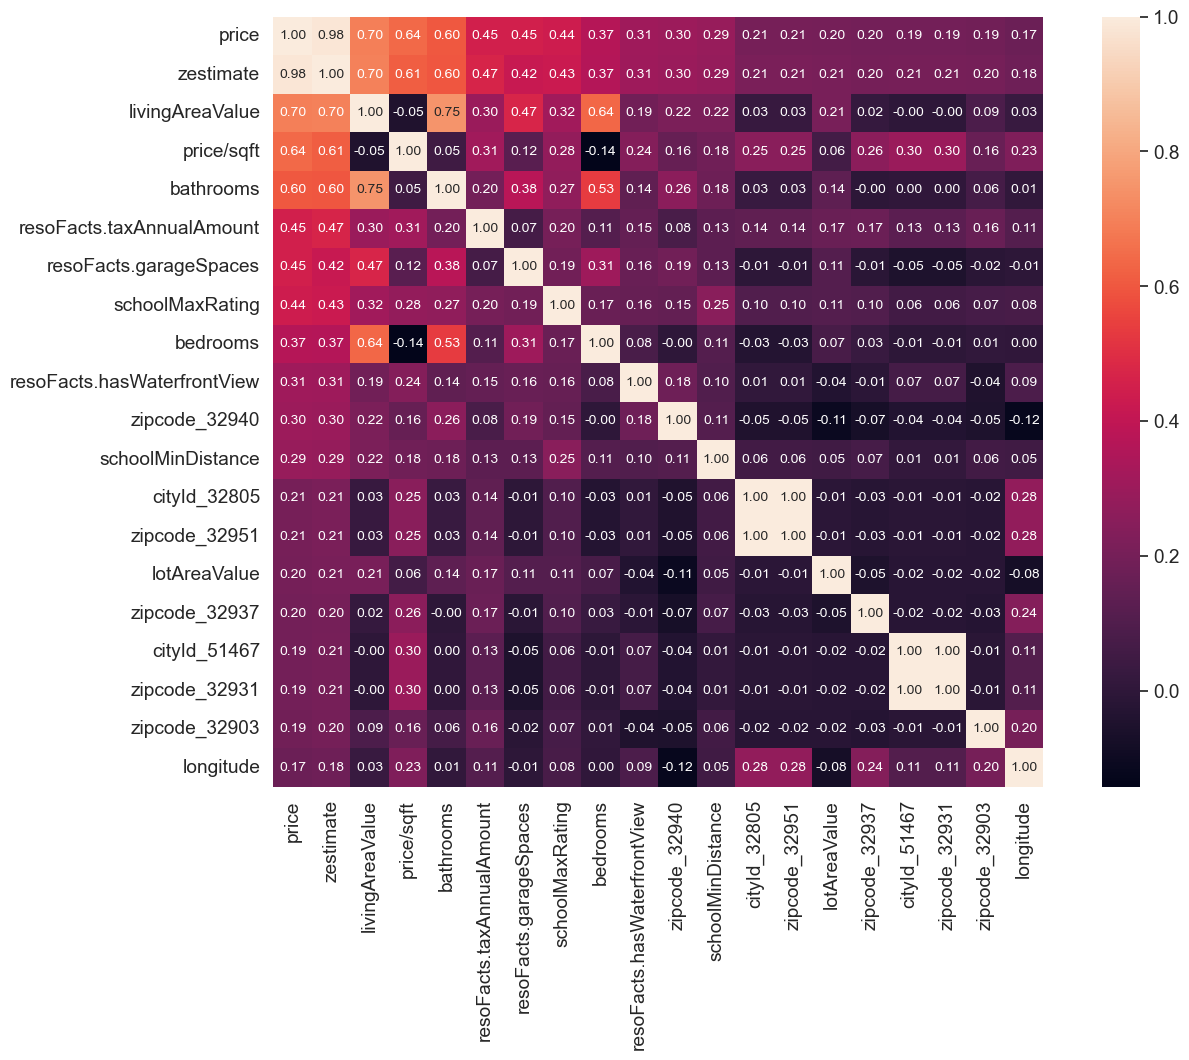

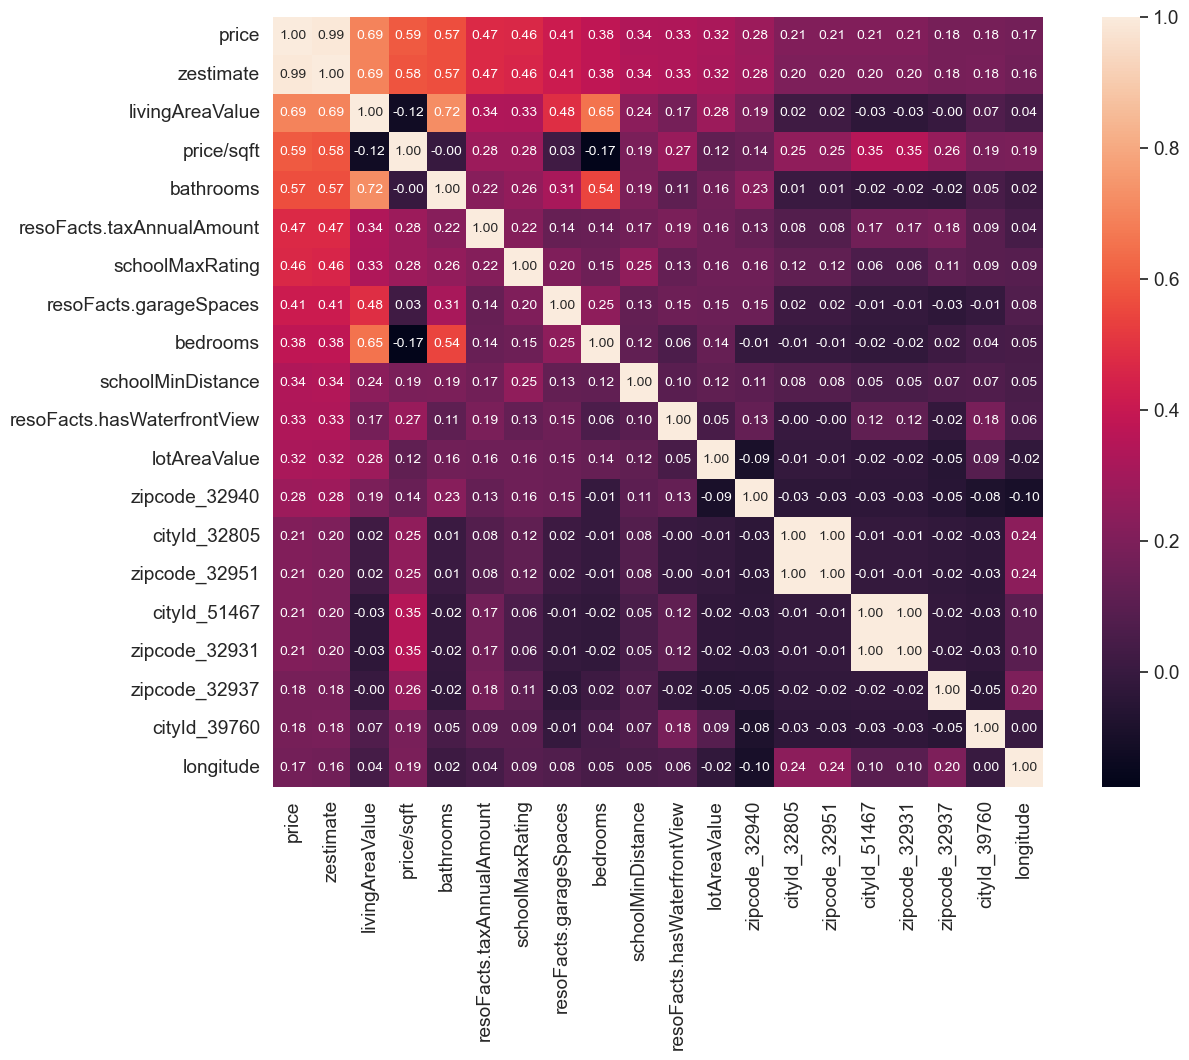

Most Correlated Features - Recently Sold  \
0                                     price   
1                                 zestimate   
2                           livingAreaValue   
3                                price/sqft   
4                                 bathrooms   
5                 resoFacts.taxAnnualAmount   
6                    resoFacts.garageSpaces   
7                           schoolMaxRating   
8                                  bedrooms   
9               resoFacts.hasWaterfrontView   
10                            zipcode_32940   
11                        schoolMinDistance   
12                             cityId_32805   
13                            zipcode_32951   
14                             lotAreaValue   
15                            zipcode_32937   
16                             cityId_51467   
17                            zipcode_32931   
18                            zipcode_32903   
19                                longitude   

   Most Correlated Features - For Sale  
0                                price  
1                            zestimate  
2                      livingAreaValue  
3                           price/sqft  
4                            bathrooms  
5            resoFacts.taxAnnualAmount  
6                      schoolMaxRating  
7               resoFacts.garageSpaces  
8                             bedrooms  
9                    schoolMinDistance  
10         resoFacts.hasWaterfrontView  
11                        lotAreaValue  
12                       zipcode_32940  
13                        cityId_32805  
14                       zipcode_32951  
15                        cityId_51467  
16                       zipcode_32931  
17                       zipcode_32937  
18                        cityId_39760  
19                           longitude

In [35]:
'''
Checking feature correlations for possible further downselection
'''

# Correlation Matrix Heatmap
corrmat = df_recentlySold_trunc[numCols].corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=False)

# Correlation Heatmap: Top 20 Features
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df_recentlySold_trunc[cols].values.T)
sns.set_theme(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features - Recently Sold']

# Correlation Matrix Heatmap
corrmat = df_forSale_trunc[numCols].corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=False)

# Correlation Heatmap: Top 20 Features
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df_forSale_trunc[cols].values.T)
sns.set_theme(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


most_corr['Most Correlated Features - For Sale'] = cols
most_corr

In [36]:
'''
Remind ourselves of the distribution before applying transformations
'''

print('Recently Sold Data:')
print('Skewness: %f' % df_recentlySold_trunc['price'].skew())
print('Kurtosis: %f' % df_recentlySold_trunc['price'].kurt())
print('')
print('For Sale Data:')
print('Skewness: %f' % df_forSale_trunc['price'].skew())
print('Kurtosis: %f' % df_forSale_trunc['price'].kurt())

Recently Sold Data:
Skewness: 1.150068
Kurtosis: 1.120710

For Sale Data:
Skewness: 1.196056
Kurtosis: 0.858272


In [37]:
# # We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
# df_recentlySold_trunc['price'] = np.log1p(df_recentlySold_trunc['price'])
# df_forSale_trunc['price'] = np.log1p(df_forSale_trunc['price'])

# # Plot Histogram
# sns.displot(df_recentlySold_trunc['price'])

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(df_recentlySold_trunc['price'])
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# plt.ylabel('Frequency')
# plt.title('SalePrice distribution')

# fig = plt.figure()
# res = stats.probplot(df_recentlySold_trunc['price'], plot=plt)
# plt.show()
# print('Recently Sold Data:')
# print('Skewness: %f' % df_recentlySold_trunc['price'].skew()) # <-- Measure of lack of left-to-right symmetry. High vale = less symmetric
# print('Kurtosis: %f' % df_recentlySold_trunc['price'].kurt()) # <-- Measure of heavy tailed or lightly tailed. High value = heavy tail
# print('')

# # Plot Histogram
# sns.displot(df_forSale_trunc['price'])

# # Get the fitted parameters used by the function
# (mu, sigma) = norm.fit(df_forSale_trunc['price'])
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# plt.ylabel('Frequency')
# plt.title('SalePrice distribution')

# fig = plt.figure()
# res = stats.probplot(df_forSale_trunc['price'], plot=plt)
# plt.show()
# print('For Sale Data:')
# print('Skewness: %f' % df_forSale_trunc['price'].skew())
# print('Kurtosis: %f' % df_forSale_trunc['price'].kurt())

In [38]:
'''

'''

# # Check the skew of all numerical features
# skewed_feats = df_recentlySold_trunc[numCols[0:14]].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
# print(skewness.head())

# skewness = skewness[abs(skewness) > 0.75].dropna()
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

# from scipy.special import boxcox1p
# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:
#     if feat not in ['resoFacts.isSeniorCommunity', 'resoFacts.hasWaterfrontView']:
#         df_recentlySold_trunc[feat] = boxcox1p(df_recentlySold_trunc[feat], lam)
#         df_recentlySold_trunc[feat] += 1


# # Check the skew of all numerical features
# skewed_feats = df_forSale_trunc[numCols[0:14]].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
# print(skewness.head())

# skewness = skewness[abs(skewness) > 0.75].dropna()
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

# from scipy.special import boxcox1p
# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:
#     if feat not in ['resoFacts.isSeniorCommunity', 'resoFacts.hasWaterfrontView']:
#         df_forSale_trunc[feat] = boxcox1p(df_recentlySold_trunc[feat], lam)
#         df_forSale_trunc[feat] += 1

'\n\n'

In [39]:
'''
Create new CSV file with all cleaned and wrangled data.
'''

# Rename price column to be more clear
df_forSale_trunc.rename(columns={'price':'listPrice'}, inplace=True)
df_recentlySold_trunc.rename(columns={'price':'soldPrice'}, inplace=True)

# Export dataframes to csv
df_forSale_trunc.to_csv('cleaned_forSale_data.csv', sep=',', index=True, encoding='utf-8')
df_recentlySold_trunc.to_csv('cleaned_recentlySold_data.csv', sep=',', index=True, encoding='utf-8')
# del df_recentlySold_trunc, df_forSale_trunc

---
End of section.
## <pre><-- Previous: Data Collection                        Next: EDA --></pre>